In [4]:
import os
import sys
import importlib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [5]:
project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))

def pickle_save(obj: object, relative_path: str) -> None:
    pickle.dump(obj, open(join_path(relative_path), 'wb'))

In [6]:
sys.path.append(join_path('EMIT-ECOSTRESS\\modules'))
import datasets.Datasets
import models.Feedforward
import utils.train
import utils.eval

In [7]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [8]:
base_data_path = 'Data\\Dataset\\Splits'
log_file_path = join_path(r'Miscellaneous\small_nn_benchmark_log.txt')

# load data

emit_train = pickle_load(
    os.path.join(base_data_path, 'reflectance_train_pca244.pkl')
)
emit_val = pickle_load(
    os.path.join(base_data_path, 'reflectance_val_pca244.pkl')
)

elev_train = pickle_load(
    os.path.join(base_data_path, 'elevation_train.pkl')
)
elev_val = pickle_load(os.path.join(base_data_path, 'elevation_val.pkl'))

elev_train = (
    (
        elev_train - np.mean(np.concatenate([elev_train, elev_val], axis=1))
    ) / 
    np.std(np.concatenate([elev_train, elev_val], axis=1))
)
elev_val = (
    (
        elev_val - np.mean(np.concatenate([elev_train, elev_val], axis=1))
    ) / 
    np.std(np.concatenate([elev_train, elev_val], axis=1))
)
eco_train = pickle_load(os.path.join(base_data_path, 'temp_train.pkl'))
eco_val = pickle_load(os.path.join(base_data_path, 'temp_val.pkl'))

In [13]:
benchmark_combos = [
    # (0, 0), (0, 1),
    (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 8),
    # (0, 10), (0, 12), (0, 16), (0, 24), (0, 32), (0, 48), (0, 64),
    # (0, 96), (0, 128), (0, 244),
    (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8),# (1, 16), (1, 32), (1, 48), (1, 64),
    (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8),# (2, 16), (2, 32), (2, 48),
    (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8),# (3, 16), (3, 32), (3, 48),
    (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8),# (4, 16), (4, 32), (4, 48),
    (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8),# (5, 16), (5, 32), (5, 48),
    (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8),# (6, 16), (6, 32),
    # (7, 2), (7, 4), (7, 8),# (7, 16),
    (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8),# (8, 16),
    # (9, 2), (9, 4), (9, 8),
    (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8),
    # (11, 2), (11, 4), (11, 6),
    (12, 2), (12, 3), (12, 4), (12, 5), (12, 6), (12, 7), (12, 8),
    # (13, 2), (13, 3), (13, 4), (13, 5),
    # (14, 2), (14, 3), (14, 4), (14, 5),
    # (15, 2), (15, 3), (15, 4), (15, 5),
    (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8),
    # (17, 2), (17, 3), (17, 4), (17, 5),
    # (18, 2), (18, 3), (18, 4), (18, 5),
    # (19, 2), (19, 3), (19, 4), (19, 5),
    (20, 2), (20, 3), (20, 4),# (20, 5),
    # (21, 2), (21, 3), (21, 4), (21, 5),
    # (22, 2), (22, 3), (22, 4), (22, 5),
    # (23, 2), (23, 3), (23, 4), (23, 5),
    (24, 2), (24, 3), (24, 4),# (24, 5),
    (32, 2), (32, 3), (32, 4),# (32, 5),
]

# benchmark_combos = [
#     (6, 4),
#     (6, 8),
#     (10, 2),
#     (10, 4),
#     (10, 8),
#     (12, 2),
#     (12, 3),
#     (12, 6),
#     (14, 3),
#     (16, 2),
#     (16, 3),
#     (16, 4),
#     (18, 3),
#     (18, 5),
#     (20, 2),
#     (22, 2),
# ]

len(benchmark_combos)

85

radius=0, n_components=2
 ToyModel(
  (linear1): Linear(in_features=3, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.5088,  4.4755   	 Val (RMSE, K):  1.4337,  3.8429   	LR:  0.001	Time: 15.2
Epoch 001:     Train (RMSE, K):  1.0776,  3.1963   	 Val (RMSE, K):  0.87401,  2.3427   	LR:  0.001	Time: 17.9
Epoch 002:     Train (RMSE, K):  0.90132,  2.6735   	 Val (RMSE, K):  0.9018,  2.4172   	LR:  0.001	Time: 18.5
Epoch 003:     Train (RMSE, K):  0.86323,  2.5605   	 Val (RMSE, K):  0.93738,  2.5126   	LR:  0.001	Time: 19.1
Epoch 004:     Train (RMSE, K):  0.83295,  2.4707   	 Val (RMSE, K):  0.90968,  2.4383   	LR:  0.001	Time: 17.9
Epoch 005:     Train (RMSE, K):  0.8296,  2.4608   	 Val (RMSE, K):  0.92287,  2.4737   	LR: 0.0002	Time: 18.2


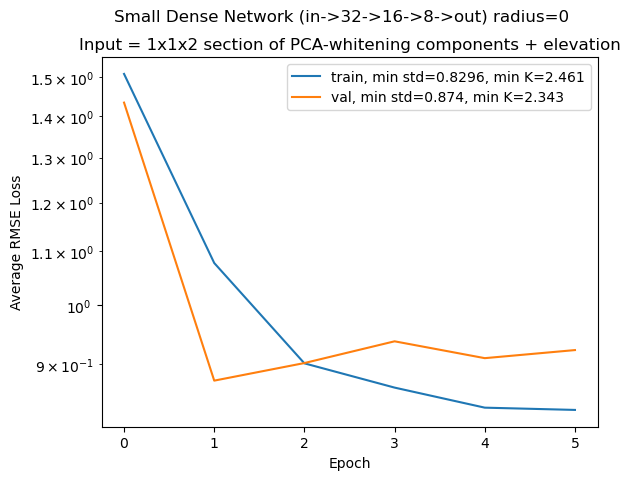

radius=0, n_components=3
 ToyModel(
  (linear1): Linear(in_features=4, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2707,  3.7693   	 Val (RMSE, K):  0.89645,  2.4029   	LR:  0.001	Time: 16.7
Epoch 001:     Train (RMSE, K):  0.92873,  2.7548   	 Val (RMSE, K):  0.77243,  2.0704   	LR:  0.001	Time: 17.4
Epoch 002:     Train (RMSE, K):  0.83945,    2.49   	 Val (RMSE, K):  0.82807,  2.2196   	LR:  0.001	Time: 17.4
Epoch 003:     Train (RMSE, K):  0.81571,  2.4196   	 Val (RMSE, K):  0.92715,  2.4852   	LR:  0.001	Time: 17.4
Epoch 004:     Train (RMSE, K):  0.8117,  2.4077   	 Val (RMSE, K):  1.0008,  2.6825   	LR:  0.001	Time: 17.0
Epoch 005:     Train (RMSE, K):  0.80738,  2.3949   	 Val (RMSE, K):  1.0042,  2.6917   	LR: 0.0002	Time: 15.9


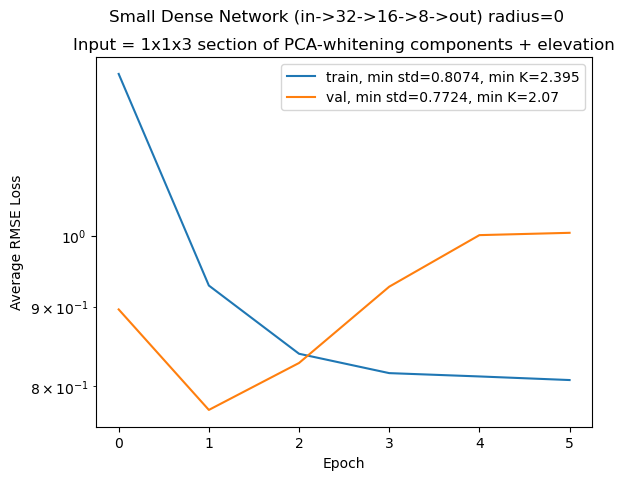

radius=0, n_components=4
 ToyModel(
  (linear1): Linear(in_features=5, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1739,   3.482   	 Val (RMSE, K):   1.108,    2.97   	LR:  0.001	Time: 14.8
Epoch 001:     Train (RMSE, K):  0.94932,  2.8159   	 Val (RMSE, K):  1.2786,  3.4273   	LR:  0.001	Time: 15.6
Epoch 002:     Train (RMSE, K):  0.83437,  2.4749   	 Val (RMSE, K):  1.2436,  3.3333   	LR:  0.001	Time: 15.6
Epoch 003:     Train (RMSE, K):  0.7974,  2.3653   	 Val (RMSE, K):  1.2032,  3.2251   	LR:  0.001	Time: 15.9
Epoch 004:     Train (RMSE, K):  0.79007,  2.3435   	 Val (RMSE, K):  1.2192,   3.268   	LR: 0.0002	Time: 15.8
Epoch 005:     Train (RMSE, K):  0.78079,   2.316   	 Val (RMSE, K):  1.2454,  3.3381   	LR: 0.0002	Time: 18.1


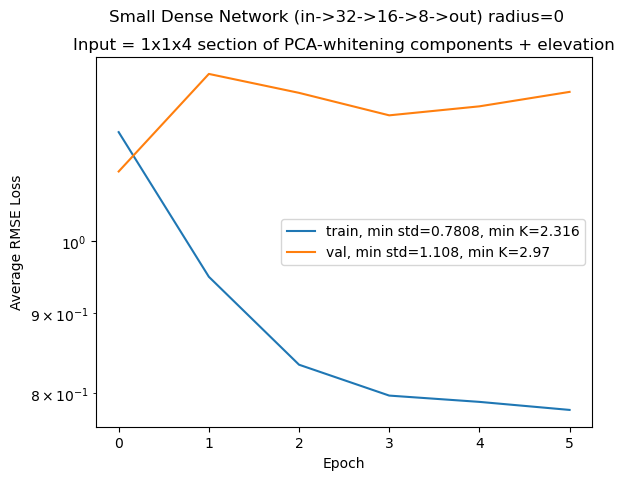

radius=0, n_components=5
 ToyModel(
  (linear1): Linear(in_features=6, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.0465,  3.1042   	 Val (RMSE, K):  0.88991,  2.3853   	LR:  0.001	Time: 15.5
Epoch 001:     Train (RMSE, K):  0.87819,  2.6049   	 Val (RMSE, K):  0.82939,  2.2231   	LR:  0.001	Time: 15.9
Epoch 002:     Train (RMSE, K):  0.80137,   2.377   	 Val (RMSE, K):  0.83445,  2.2367   	LR:  0.001	Time: 15.8
Epoch 003:     Train (RMSE, K):  0.78749,  2.3359   	 Val (RMSE, K):  0.83409,  2.2357   	LR:  0.001	Time: 15.6
Epoch 004:     Train (RMSE, K):  0.77565,  2.3008   	 Val (RMSE, K):  0.83815,  2.2466   	LR:  0.001	Time: 15.6
Epoch 005:     Train (RMSE, K):  0.77125,  2.2877   	 Val (RMSE, K):  0.84686,  2.2699   	LR: 0.0002	Time: 15.8


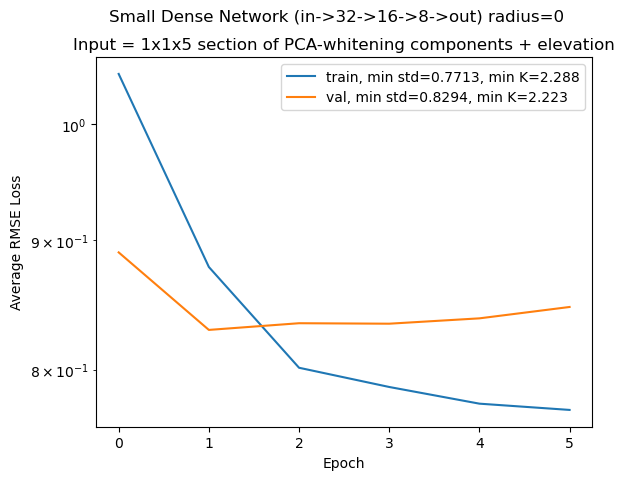

radius=0, n_components=6
 ToyModel(
  (linear1): Linear(in_features=7, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1042,  3.2754   	 Val (RMSE, K):  1.1295,  3.0275   	LR:  0.001	Time: 14.9
Epoch 001:     Train (RMSE, K):  0.94968,   2.817   	 Val (RMSE, K):  0.99405,  2.6645   	LR:  0.001	Time: 15.8
Epoch 002:     Train (RMSE, K):  0.82615,  2.4505   	 Val (RMSE, K):  0.96505,  2.5867   	LR:  0.001	Time: 16.0
Epoch 003:     Train (RMSE, K):  0.81626,  2.4212   	 Val (RMSE, K):  1.0181,   2.729   	LR:  0.001	Time: 15.8
Epoch 004:     Train (RMSE, K):  0.80924,  2.4004   	 Val (RMSE, K):  1.0389,  2.7848   	LR:  0.001	Time: 15.7
Epoch 005:     Train (RMSE, K):  0.80125,  2.3767   	 Val (RMSE, K):  1.0495,  2.8132   	LR:  0.001	Time: 15.9


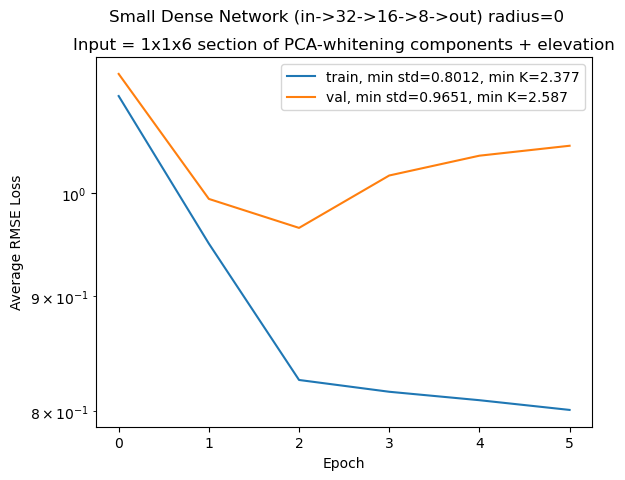

radius=0, n_components=8
 ToyModel(
  (linear1): Linear(in_features=9, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  0.95921,  2.8452   	 Val (RMSE, K):  0.81109,  2.1741   	LR:  0.001	Time: 14.9
Epoch 001:     Train (RMSE, K):  0.84791,  2.5151   	 Val (RMSE, K):  1.0335,  2.7703   	LR:  0.001	Time: 15.8
Epoch 002:     Train (RMSE, K):  0.79042,  2.3446   	 Val (RMSE, K):  1.0486,  2.8108   	LR:  0.001	Time: 15.8
Epoch 003:     Train (RMSE, K):  0.77726,  2.3055   	 Val (RMSE, K):  1.0487,   2.811   	LR:  0.001	Time: 15.7
Epoch 004:     Train (RMSE, K):  0.77779,  2.3071   	 Val (RMSE, K):  1.0317,  2.7653   	LR: 0.0002	Time: 15.8
Epoch 005:     Train (RMSE, K):  0.77596,  2.3017   	 Val (RMSE, K):  1.0298,  2.7603   	LR: 0.0002	Time: 15.9


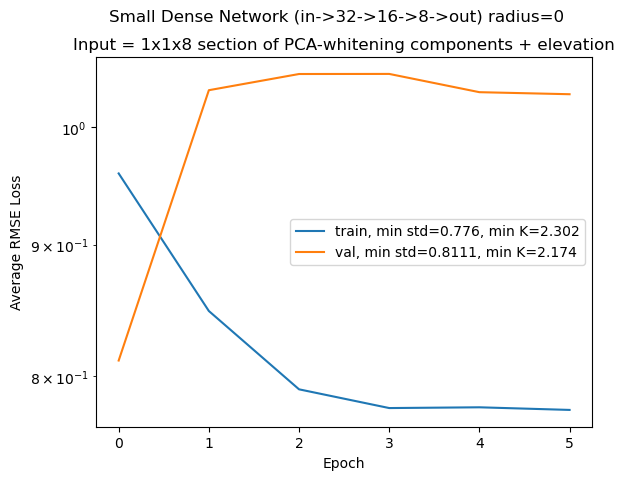

radius=1, n_components=2
 ToyModel(
  (linear1): Linear(in_features=27, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2356,   3.665   	 Val (RMSE, K):  1.0118,  2.7119   	LR:  0.001	Time: 16.8
Epoch 001:     Train (RMSE, K):  0.86382,  2.5623   	 Val (RMSE, K):  0.8498,  2.2778   	LR:  0.001	Time: 17.8
Epoch 002:     Train (RMSE, K):  0.82672,  2.4522   	 Val (RMSE, K):  0.83346,   2.234   	LR:  0.001	Time: 17.7
Epoch 003:     Train (RMSE, K):  0.81824,  2.4271   	 Val (RMSE, K):  0.89024,  2.3862   	LR:  0.001	Time: 17.7
Epoch 004:     Train (RMSE, K):  0.80307,  2.3821   	 Val (RMSE, K):  0.90279,  2.4199   	LR:  0.001	Time: 17.7
Epoch 005:     Train (RMSE, K):  0.7988,  2.3694   	 Val (RMSE, K):  0.90565,  2.4275   	LR:  0.001	Time: 17.8


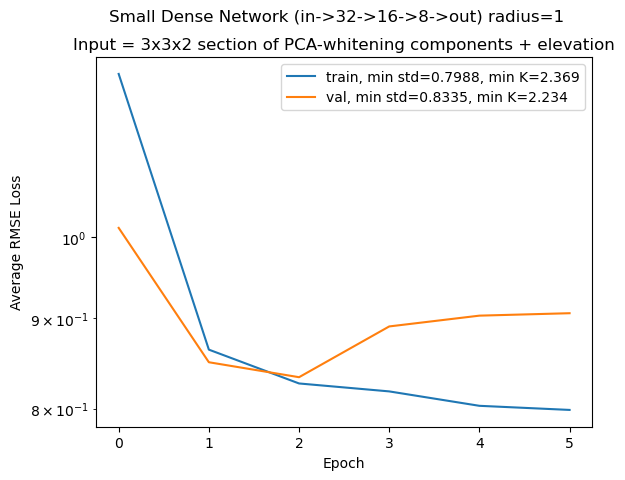

radius=1, n_components=3
 ToyModel(
  (linear1): Linear(in_features=36, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.6226,   4.813   	 Val (RMSE, K):  1.4163,  3.7962   	LR:  0.001	Time: 16.9
Epoch 001:     Train (RMSE, K):  0.93084,  2.7611   	 Val (RMSE, K):  0.7545,  2.0224   	LR:  0.001	Time: 18.1
Epoch 002:     Train (RMSE, K):  0.80343,  2.3832   	 Val (RMSE, K):  0.91063,  2.4409   	LR:  0.001	Time: 18.1
Epoch 003:     Train (RMSE, K):  0.78046,   2.315   	 Val (RMSE, K):  0.97107,  2.6029   	LR:  0.001	Time: 18.1
Epoch 004:     Train (RMSE, K):  0.77258,  2.2917   	 Val (RMSE, K):  1.0407,  2.7895   	LR:  0.001	Time: 18.0
Epoch 005:     Train (RMSE, K):  0.76592,  2.2719   	 Val (RMSE, K):  1.0359,  2.7767   	LR: 0.0002	Time: 18.5


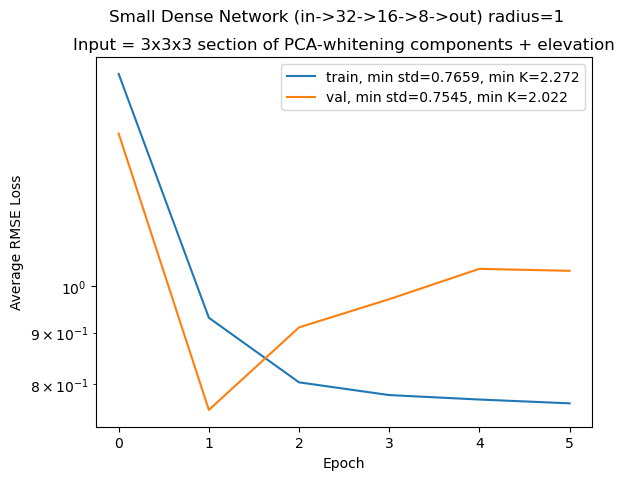

radius=1, n_components=4
 ToyModel(
  (linear1): Linear(in_features=45, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1584,   3.436   	 Val (RMSE, K):  0.97225,   2.606   	LR:  0.001	Time: 17.1
Epoch 001:     Train (RMSE, K):  0.85926,  2.5488   	 Val (RMSE, K):  0.7774,  2.0838   	LR:  0.001	Time: 18.1
Epoch 002:     Train (RMSE, K):  0.81559,  2.4192   	 Val (RMSE, K):  0.97655,  2.6176   	LR:  0.001	Time: 18.1
Epoch 003:     Train (RMSE, K):  0.81632,  2.4214   	 Val (RMSE, K):  1.0378,  2.7817   	LR:  0.001	Time: 17.9
Epoch 004:     Train (RMSE, K):  0.81016,  2.4031   	 Val (RMSE, K):  0.98963,  2.6526   	LR:  0.001	Time: 17.9
Epoch 005:     Train (RMSE, K):  0.80351,  2.3834   	 Val (RMSE, K):  1.0077,   2.701   	LR: 0.0002	Time: 18.0


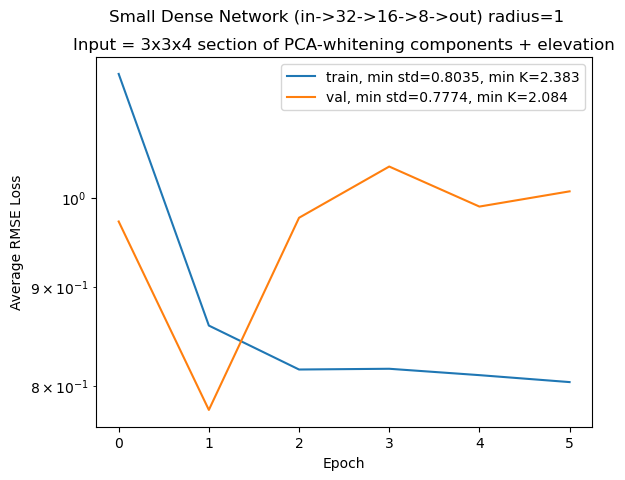

radius=1, n_components=5
 ToyModel(
  (linear1): Linear(in_features=54, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.3364,  3.9642   	 Val (RMSE, K):  1.0029,  2.6881   	LR:  0.001	Time: 17.1
Epoch 001:     Train (RMSE, K):  0.86601,  2.5688   	 Val (RMSE, K):  0.95935,  2.5715   	LR:  0.001	Time: 18.0
Epoch 002:     Train (RMSE, K):  0.78069,  2.3157   	 Val (RMSE, K):  0.95218,  2.5522   	LR:  0.001	Time: 18.0
Epoch 003:     Train (RMSE, K):  0.77381,  2.2953   	 Val (RMSE, K):  0.95236,  2.5527   	LR:  0.001	Time: 18.0
Epoch 004:     Train (RMSE, K):  0.76978,  2.2833   	 Val (RMSE, K):  0.92576,  2.4814   	LR:  0.001	Time: 17.9
Epoch 005:     Train (RMSE, K):  0.76481,  2.2686   	 Val (RMSE, K):  0.90011,  2.4127   	LR:  0.001	Time: 18.4


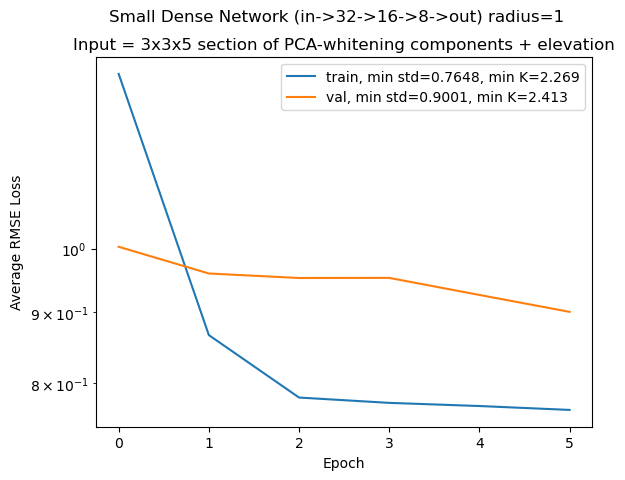

radius=1, n_components=6
 ToyModel(
  (linear1): Linear(in_features=63, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.6241,  4.8175   	 Val (RMSE, K):  1.3984,  3.7484   	LR:  0.001	Time: 17.3
Epoch 001:     Train (RMSE, K):  0.87925,   2.608   	 Val (RMSE, K):  1.0214,  2.7379   	LR:  0.001	Time: 18.0
Epoch 002:     Train (RMSE, K):  0.79054,  2.3449   	 Val (RMSE, K):  0.9558,  2.5619   	LR:  0.001	Time: 18.0
Epoch 003:     Train (RMSE, K):  0.77742,   2.306   	 Val (RMSE, K):  1.0139,  2.7178   	LR:  0.001	Time: 18.1
Epoch 004:     Train (RMSE, K):  0.77242,  2.2912   	 Val (RMSE, K):  0.99045,  2.6548   	LR:  0.001	Time: 19.3
Epoch 005:     Train (RMSE, K):  0.76853,  2.2796   	 Val (RMSE, K):  1.0759,  2.8838   	LR:  0.001	Time: 18.3


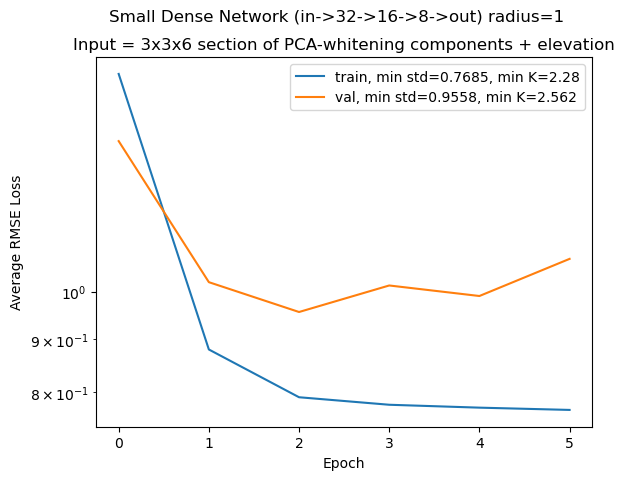

radius=1, n_components=7
 ToyModel(
  (linear1): Linear(in_features=72, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):    1.65,  4.8943   	 Val (RMSE, K):  1.0885,  2.9177   	LR:  0.001	Time: 17.2
Epoch 001:     Train (RMSE, K):  0.87289,  2.5892   	 Val (RMSE, K):  0.83027,  2.2255   	LR:  0.001	Time: 17.8
Epoch 002:     Train (RMSE, K):  0.7859,  2.3312   	 Val (RMSE, K):  0.95799,  2.5678   	LR:  0.001	Time: 18.3
Epoch 003:     Train (RMSE, K):  0.77677,  2.3041   	 Val (RMSE, K):  0.92867,  2.4892   	LR:  0.001	Time: 18.1
Epoch 004:     Train (RMSE, K):  0.77479,  2.2982   	 Val (RMSE, K):  1.0178,  2.7282   	LR:  0.001	Time: 18.1
Epoch 005:     Train (RMSE, K):  0.77112,  2.2873   	 Val (RMSE, K):  1.0334,    2.77   	LR: 0.0002	Time: 18.4


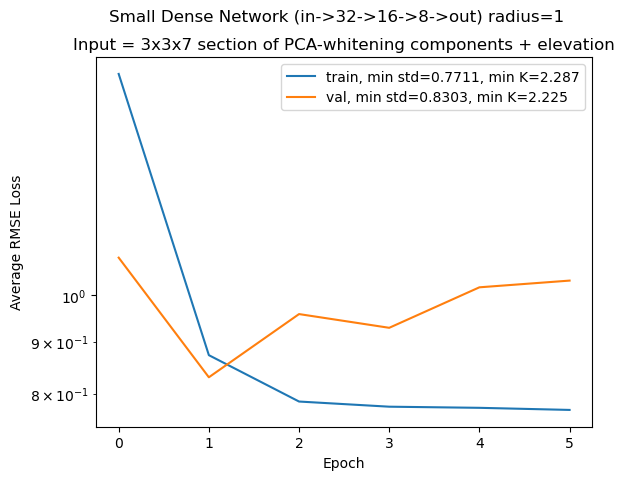

radius=1, n_components=8
 ToyModel(
  (linear1): Linear(in_features=81, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2456,  3.6949   	 Val (RMSE, K):  1.0091,  2.7047   	LR:  0.001	Time: 17.1
Epoch 001:     Train (RMSE, K):  0.95306,   2.827   	 Val (RMSE, K):  0.86139,  2.3089   	LR:  0.001	Time: 18.2
Epoch 002:     Train (RMSE, K):  0.79068,  2.3453   	 Val (RMSE, K):  0.9361,  2.5092   	LR:  0.001	Time: 18.3
Epoch 003:     Train (RMSE, K):  0.77206,  2.2901   	 Val (RMSE, K):  0.93804,  2.5144   	LR:  0.001	Time: 18.1
Epoch 004:     Train (RMSE, K):  0.76785,  2.2776   	 Val (RMSE, K):  1.0401,  2.7878   	LR:  0.001	Time: 18.1
Epoch 005:     Train (RMSE, K):  0.7615,  2.2588   	 Val (RMSE, K):   1.045,   2.801   	LR: 0.0002	Time: 18.2


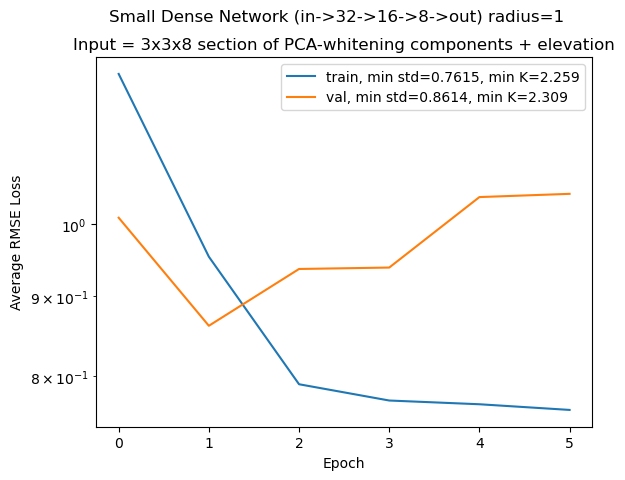

radius=2, n_components=2
 ToyModel(
  (linear1): Linear(in_features=75, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  0.89136,   2.644   	 Val (RMSE, K):  0.97655,  2.6176   	LR:  0.001	Time: 18.5
Epoch 001:     Train (RMSE, K):  0.81082,  2.4051   	 Val (RMSE, K):  0.77451,   2.076   	LR:  0.001	Time: 19.8
Epoch 002:     Train (RMSE, K):  0.79518,  2.3587   	 Val (RMSE, K):  0.76671,  2.0551   	LR:  0.001	Time: 19.8
Epoch 003:     Train (RMSE, K):  0.79113,  2.3467   	 Val (RMSE, K):  0.72518,  1.9438   	LR:  0.001	Time: 19.9
Epoch 004:     Train (RMSE, K):  0.77503,  2.2989   	 Val (RMSE, K):  0.74322,  1.9921   	LR:  0.001	Time: 20.0
Epoch 005:     Train (RMSE, K):  0.76702,  2.2751   	 Val (RMSE, K):  0.7368,  1.9749   	LR:  0.001	Time: 20.1


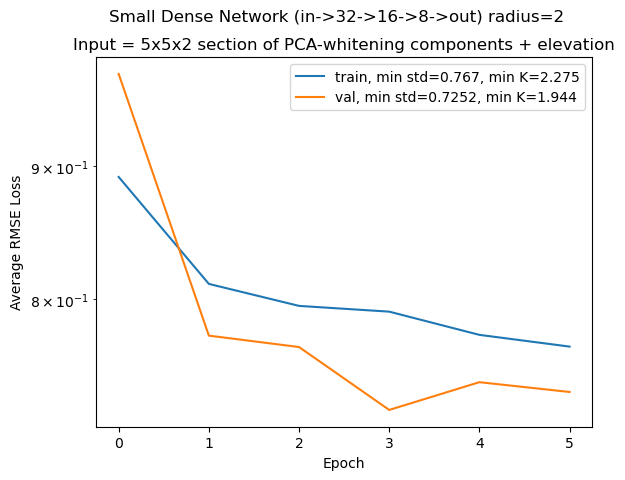

radius=2, n_components=3
 ToyModel(
  (linear1): Linear(in_features=100, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.4192,  4.2097   	 Val (RMSE, K):  1.2409,   3.326   	LR:  0.001	Time: 19.0
Epoch 001:     Train (RMSE, K):  0.82244,  2.4396   	 Val (RMSE, K):  0.85717,  2.2976   	LR:  0.001	Time: 20.2
Epoch 002:     Train (RMSE, K):  0.78109,  2.3169   	 Val (RMSE, K):  0.84932,  2.2765   	LR:  0.001	Time: 20.1
Epoch 003:     Train (RMSE, K):  0.77653,  2.3034   	 Val (RMSE, K):   1.002,  2.6857   	LR:  0.001	Time: 20.0
Epoch 004:     Train (RMSE, K):  0.77914,  2.3111   	 Val (RMSE, K):  0.93624,  2.5095   	LR:  0.001	Time: 20.2
Epoch 005:     Train (RMSE, K):  0.77674,   2.304   	 Val (RMSE, K):  1.0033,  2.6893   	LR:  0.001	Time: 20.0


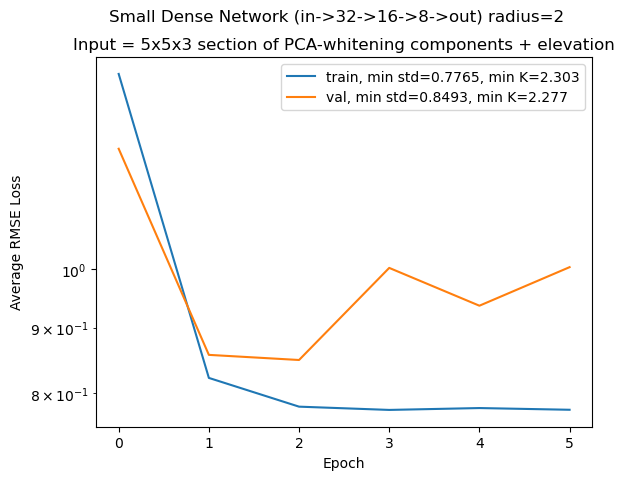

radius=2, n_components=4
 ToyModel(
  (linear1): Linear(in_features=125, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.4746,  4.3741   	 Val (RMSE, K):  1.2537,  3.3604   	LR:  0.001	Time: 18.9
Epoch 001:     Train (RMSE, K):  0.88778,  2.6334   	 Val (RMSE, K):  0.75832,  2.0326   	LR:  0.001	Time: 20.0
Epoch 002:     Train (RMSE, K):  0.81422,  2.4152   	 Val (RMSE, K):  0.96905,  2.5975   	LR:  0.001	Time: 20.1
Epoch 003:     Train (RMSE, K):  0.78541,  2.3297   	 Val (RMSE, K):  0.97958,  2.6257   	LR:  0.001	Time: 20.0
Epoch 004:     Train (RMSE, K):  0.7794,  2.3119   	 Val (RMSE, K):  1.0862,  2.9115   	LR:  0.001	Time: 20.0
Epoch 005:     Train (RMSE, K):  0.77449,  2.2973   	 Val (RMSE, K):  1.0822,  2.9008   	LR: 0.0002	Time: 20.2


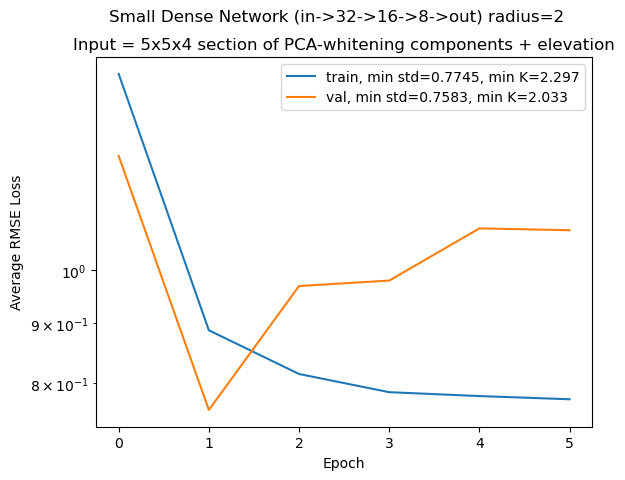

radius=2, n_components=5
 ToyModel(
  (linear1): Linear(in_features=150, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.3505,   4.006   	 Val (RMSE, K):  1.1309,  3.0313   	LR:  0.001	Time: 19.4
Epoch 001:     Train (RMSE, K):  0.9453,   2.804   	 Val (RMSE, K):  0.8036,   2.154   	LR:  0.001	Time: 20.4
Epoch 002:     Train (RMSE, K):  0.78883,  2.3398   	 Val (RMSE, K):   0.943,  2.5276   	LR:  0.001	Time: 20.3
Epoch 003:     Train (RMSE, K):  0.77972,  2.3128   	 Val (RMSE, K):  0.92256,  2.4729   	LR:  0.001	Time: 20.4
Epoch 004:     Train (RMSE, K):  0.77704,  2.3049   	 Val (RMSE, K):  1.0337,  2.7706   	LR:  0.001	Time: 20.3
Epoch 005:     Train (RMSE, K):  0.77848,  2.3091   	 Val (RMSE, K):   1.014,   2.718   	LR: 0.0002	Time: 20.3


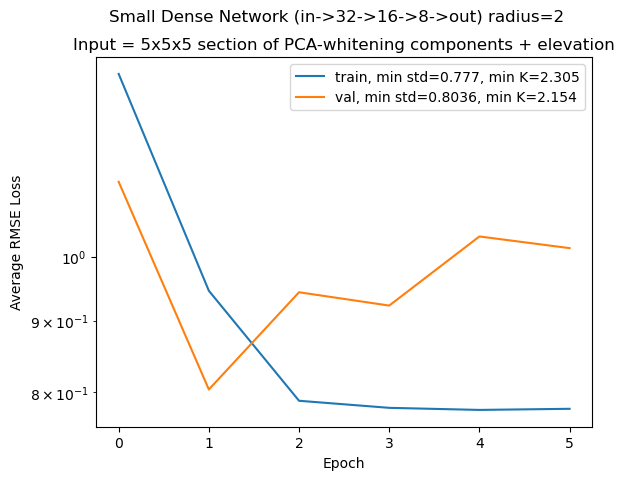

radius=2, n_components=6
 ToyModel(
  (linear1): Linear(in_features=175, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1742,  3.4829   	 Val (RMSE, K):  0.91786,  2.4603   	LR:  0.001	Time: 19.2
Epoch 001:     Train (RMSE, K):  0.85028,  2.5221   	 Val (RMSE, K):  0.87815,  2.3538   	LR:  0.001	Time: 20.3
Epoch 002:     Train (RMSE, K):  0.7806,  2.3154   	 Val (RMSE, K):  1.0258,  2.7496   	LR:  0.001	Time: 20.4
Epoch 003:     Train (RMSE, K):  0.78002,  2.3137   	 Val (RMSE, K):  0.96032,  2.5741   	LR:  0.001	Time: 20.4
Epoch 004:     Train (RMSE, K):  0.77556,  2.3005   	 Val (RMSE, K):  0.91562,  2.4543   	LR:  0.001	Time: 20.3
Epoch 005:     Train (RMSE, K):  0.7739,  2.2956   	 Val (RMSE, K):  0.93321,  2.5014   	LR: 0.0002	Time: 20.7


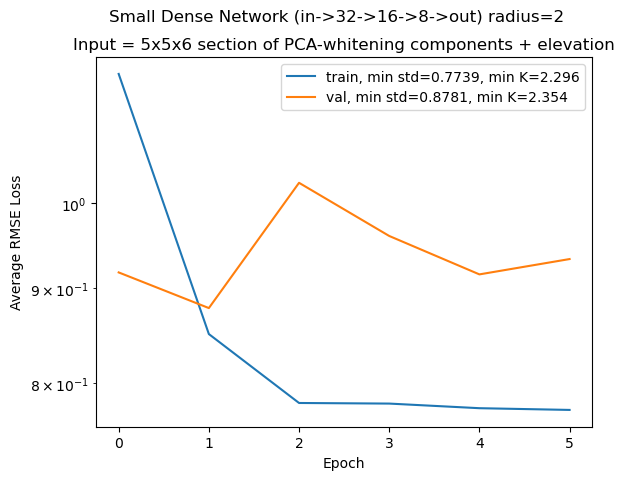

radius=2, n_components=7
 ToyModel(
  (linear1): Linear(in_features=200, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2113,  3.5931   	 Val (RMSE, K):  1.1372,  3.0481   	LR:  0.001	Time: 19.5
Epoch 001:     Train (RMSE, K):  0.88038,  2.6114   	 Val (RMSE, K):  0.90662,  2.4301   	LR:  0.001	Time: 20.6
Epoch 002:     Train (RMSE, K):  0.78135,  2.3177   	 Val (RMSE, K):  0.87787,  2.3531   	LR:  0.001	Time: 20.5
Epoch 003:     Train (RMSE, K):  0.77618,  2.3023   	 Val (RMSE, K):  0.91758,  2.4595   	LR:  0.001	Time: 20.5
Epoch 004:     Train (RMSE, K):  0.77112,  2.2873   	 Val (RMSE, K):  0.95963,  2.5722   	LR:  0.001	Time: 20.4
Epoch 005:     Train (RMSE, K):  0.77668,  2.3038   	 Val (RMSE, K):  0.98074,  2.6288   	LR:  0.001	Time: 20.7


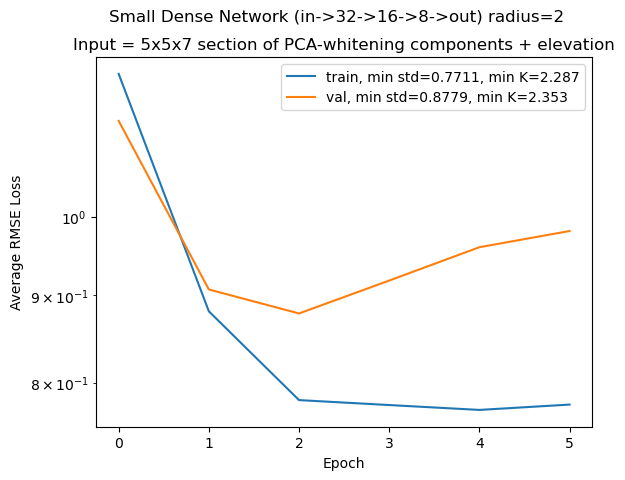

radius=2, n_components=8
 ToyModel(
  (linear1): Linear(in_features=225, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.6012,  4.7494   	 Val (RMSE, K):   1.297,  3.4765   	LR:  0.001	Time: 19.3
Epoch 001:     Train (RMSE, K):  0.90379,  2.6809   	 Val (RMSE, K):  0.74508,  1.9971   	LR:  0.001	Time: 20.4
Epoch 002:     Train (RMSE, K):  0.79426,   2.356   	 Val (RMSE, K):  0.80428,  2.1558   	LR:  0.001	Time: 20.4
Epoch 003:     Train (RMSE, K):  0.76969,  2.2831   	 Val (RMSE, K):  0.9032,   2.421   	LR:  0.001	Time: 20.6
Epoch 004:     Train (RMSE, K):  0.76834,  2.2791   	 Val (RMSE, K):  0.90778,  2.4332   	LR:  0.001	Time: 20.5
Epoch 005:     Train (RMSE, K):  0.76412,  2.2665   	 Val (RMSE, K):  0.90212,  2.4181   	LR: 0.0002	Time: 20.9


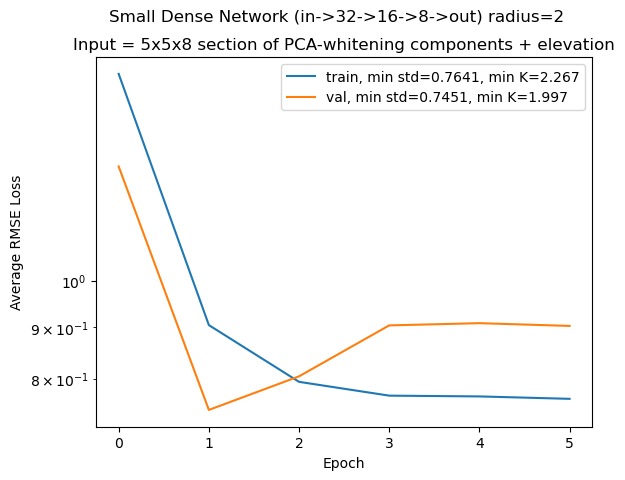

radius=3, n_components=2
 ToyModel(
  (linear1): Linear(in_features=147, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1709,  3.4731   	 Val (RMSE, K):  1.0523,  2.8205   	LR:  0.001	Time: 21.9
Epoch 001:     Train (RMSE, K):  0.96484,  2.8619   	 Val (RMSE, K):  0.91536,  2.4536   	LR:  0.001	Time: 23.4
Epoch 002:     Train (RMSE, K):  0.83944,    2.49   	 Val (RMSE, K):  0.85292,  2.2862   	LR:  0.001	Time: 23.3
Epoch 003:     Train (RMSE, K):  0.8265,  2.4516   	 Val (RMSE, K):  0.84311,  2.2599   	LR:  0.001	Time: 23.4
Epoch 004:     Train (RMSE, K):  0.82998,  2.4619   	 Val (RMSE, K):  0.8346,  2.2371   	LR:  0.001	Time: 23.4
Epoch 005:     Train (RMSE, K):  0.83167,  2.4669   	 Val (RMSE, K):  0.8595,  2.3038   	LR:  0.001	Time: 23.1


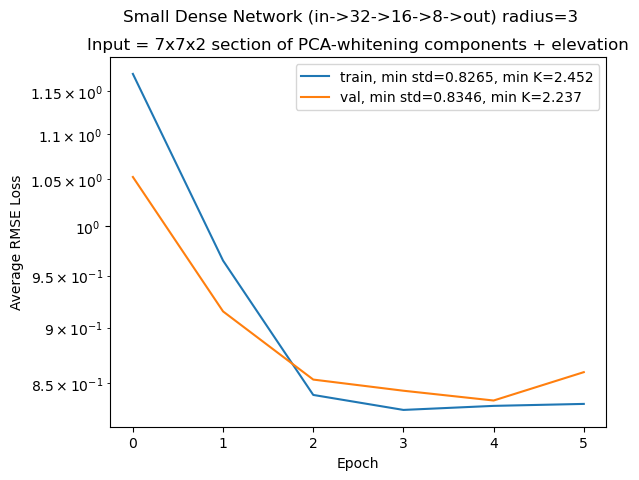

radius=3, n_components=3
 ToyModel(
  (linear1): Linear(in_features=196, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):   1.251,  3.7106   	 Val (RMSE, K):  1.2313,  3.3004   	LR:  0.001	Time: 21.6
Epoch 001:     Train (RMSE, K):  0.87469,  2.5945   	 Val (RMSE, K):  0.77817,  2.0858   	LR:  0.001	Time: 23.3
Epoch 002:     Train (RMSE, K):  0.79097,  2.3462   	 Val (RMSE, K):  0.96633,  2.5902   	LR:  0.001	Time: 23.3
Epoch 003:     Train (RMSE, K):  0.78458,  2.3272   	 Val (RMSE, K):   1.029,  2.7581   	LR:  0.001	Time: 23.5
Epoch 004:     Train (RMSE, K):  0.78283,  2.3221   	 Val (RMSE, K):  0.81162,  2.1755   	LR:  0.001	Time: 23.6
Epoch 005:     Train (RMSE, K):  0.77658,  2.3035   	 Val (RMSE, K):  0.79331,  2.1264   	LR: 0.0002	Time: 23.6


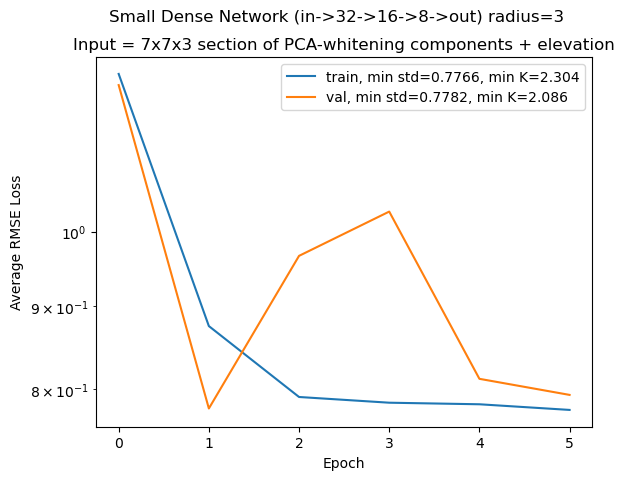

radius=3, n_components=4
 ToyModel(
  (linear1): Linear(in_features=245, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.3686,  4.0595   	 Val (RMSE, K):  1.1428,  3.0632   	LR:  0.001	Time: 21.8
Epoch 001:     Train (RMSE, K):  0.87804,  2.6045   	 Val (RMSE, K):  0.94672,  2.5376   	LR:  0.001	Time: 23.6
Epoch 002:     Train (RMSE, K):  0.81347,  2.4129   	 Val (RMSE, K):  0.96259,  2.5801   	LR:  0.001	Time: 23.4
Epoch 003:     Train (RMSE, K):  0.80764,  2.3956   	 Val (RMSE, K):   1.069,  2.8654   	LR:  0.001	Time: 23.5
Epoch 004:     Train (RMSE, K):  0.80213,  2.3793   	 Val (RMSE, K):   1.109,  2.9726   	LR:  0.001	Time: 23.6
Epoch 005:     Train (RMSE, K):  0.80257,  2.3806   	 Val (RMSE, K):  1.1231,  3.0104   	LR: 0.0002	Time: 23.8


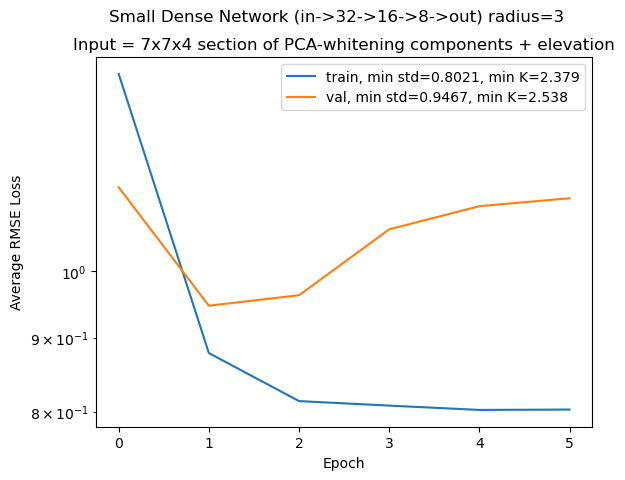

radius=3, n_components=5
 ToyModel(
  (linear1): Linear(in_features=294, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.6042,  4.7584   	 Val (RMSE, K):  1.4187,  3.8028   	LR:  0.001	Time: 22.1
Epoch 001:     Train (RMSE, K):  0.85891,  2.5477   	 Val (RMSE, K):  0.97749,  2.6201   	LR:  0.001	Time: 23.8
Epoch 002:     Train (RMSE, K):  0.7842,  2.3261   	 Val (RMSE, K):  0.91699,  2.4579   	LR:  0.001	Time: 23.6
Epoch 003:     Train (RMSE, K):  0.78627,  2.3323   	 Val (RMSE, K):  0.93348,  2.5021   	LR:  0.001	Time: 23.7
Epoch 004:     Train (RMSE, K):  0.78126,  2.3174   	 Val (RMSE, K):  0.94512,  2.5333   	LR:  0.001	Time: 23.8
Epoch 005:     Train (RMSE, K):  0.78014,  2.3141   	 Val (RMSE, K):  1.0124,  2.7136   	LR:  0.001	Time: 23.7


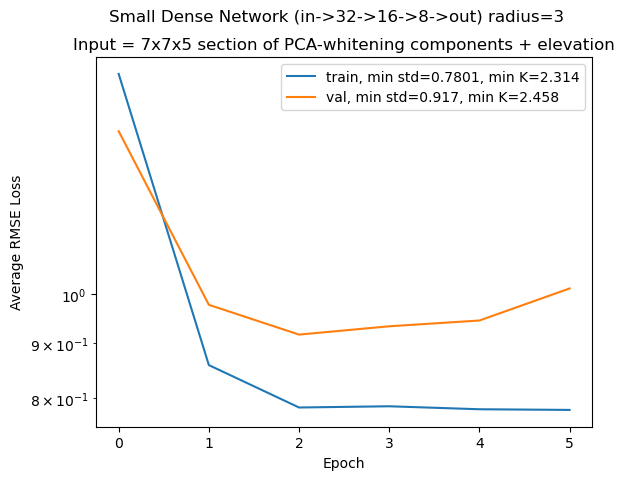

radius=3, n_components=6
 ToyModel(
  (linear1): Linear(in_features=343, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1953,  3.5455   	 Val (RMSE, K):  0.95377,  2.5565   	LR:  0.001	Time: 21.8
Epoch 001:     Train (RMSE, K):  0.84702,  2.5125   	 Val (RMSE, K):  0.82052,  2.1993   	LR:  0.001	Time: 23.5
Epoch 002:     Train (RMSE, K):  0.80015,  2.3734   	 Val (RMSE, K):   1.122,  3.0074   	LR:  0.001	Time: 23.7
Epoch 003:     Train (RMSE, K):  0.78635,  2.3325   	 Val (RMSE, K):  0.99455,  2.6658   	LR:  0.001	Time: 23.3
Epoch 004:     Train (RMSE, K):  0.77378,  2.2952   	 Val (RMSE, K):  0.90479,  2.4252   	LR:  0.001	Time: 23.5
Epoch 005:     Train (RMSE, K):  0.77077,  2.2863   	 Val (RMSE, K):  0.93449,  2.5048   	LR: 0.0002	Time: 23.7


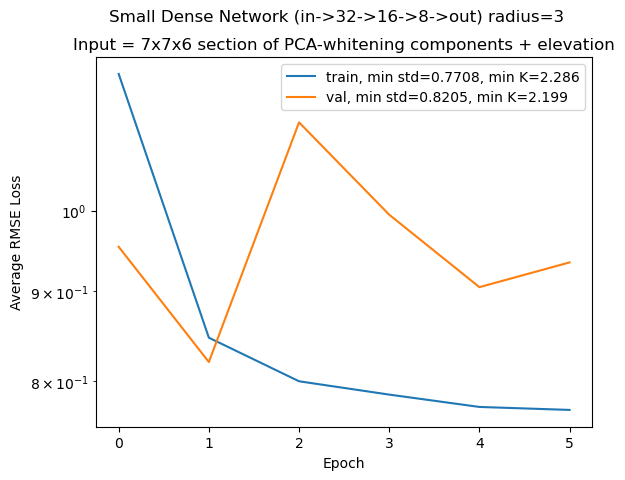

radius=3, n_components=7
 ToyModel(
  (linear1): Linear(in_features=392, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2835,  3.8072   	 Val (RMSE, K):   1.177,  3.1548   	LR:  0.001	Time: 22.6
Epoch 001:     Train (RMSE, K):  0.84348,   2.502   	 Val (RMSE, K):  0.84758,  2.2719   	LR:  0.001	Time: 23.9
Epoch 002:     Train (RMSE, K):  0.7787,  2.3098   	 Val (RMSE, K):  0.89436,  2.3973   	LR:  0.001	Time: 23.8
Epoch 003:     Train (RMSE, K):  0.77939,  2.3119   	 Val (RMSE, K):  0.91045,  2.4404   	LR:  0.001	Time: 23.7
Epoch 004:     Train (RMSE, K):  0.77038,  2.2851   	 Val (RMSE, K):  0.89807,  2.4072   	LR:  0.001	Time: 23.7
Epoch 005:     Train (RMSE, K):  0.76859,  2.2798   	 Val (RMSE, K):  0.9247,  2.4786   	LR: 0.0002	Time: 23.8


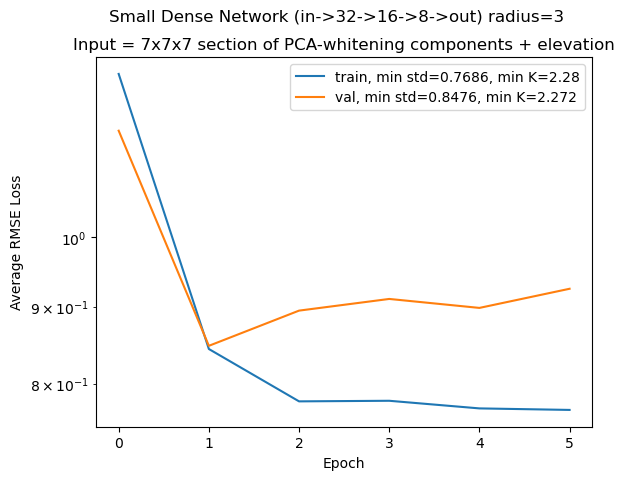

radius=3, n_components=8
 ToyModel(
  (linear1): Linear(in_features=441, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1523,   3.418   	 Val (RMSE, K):  0.9219,  2.4711   	LR:  0.001	Time: 22.2
Epoch 001:     Train (RMSE, K):  0.80148,  2.3774   	 Val (RMSE, K):  0.94901,  2.5438   	LR:  0.001	Time: 23.7
Epoch 002:     Train (RMSE, K):  0.7769,  2.3044   	 Val (RMSE, K):   1.036,  2.7769   	LR:  0.001	Time: 23.9
Epoch 003:     Train (RMSE, K):  0.77171,  2.2891   	 Val (RMSE, K):  0.97198,  2.6053   	LR:  0.001	Time: 23.8
Epoch 004:     Train (RMSE, K):  0.76544,  2.2705   	 Val (RMSE, K):  0.98164,  2.6312   	LR: 0.0002	Time: 23.8
Epoch 005:     Train (RMSE, K):  0.76396,  2.2661   	 Val (RMSE, K):  0.95306,  2.5546   	LR: 0.0002	Time: 23.9


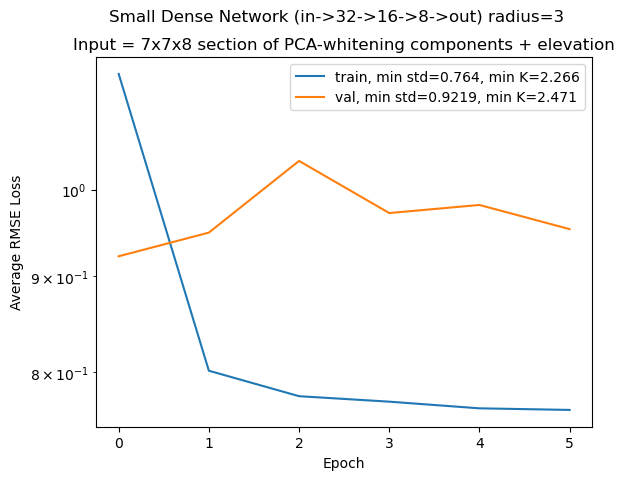

radius=4, n_components=2
 ToyModel(
  (linear1): Linear(in_features=243, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2999,  3.8557   	 Val (RMSE, K):  1.1221,  3.0077   	LR:  0.001	Time: 24.7
Epoch 001:     Train (RMSE, K):  0.84041,  2.4928   	 Val (RMSE, K):  0.93621,  2.5094   	LR:  0.001	Time: 25.3
Epoch 002:     Train (RMSE, K):  0.80155,  2.3776   	 Val (RMSE, K):  0.75711,  2.0294   	LR:  0.001	Time: 25.1
Epoch 003:     Train (RMSE, K):  0.79764,   2.366   	 Val (RMSE, K):  0.74413,  1.9946   	LR:  0.001	Time: 25.1
Epoch 004:     Train (RMSE, K):  0.79417,  2.3557   	 Val (RMSE, K):  0.8348,  2.2376   	LR:  0.001	Time: 25.0
Epoch 005:     Train (RMSE, K):  0.79649,  2.3626   	 Val (RMSE, K):  0.73266,  1.9638   	LR:  0.001	Time: 24.9


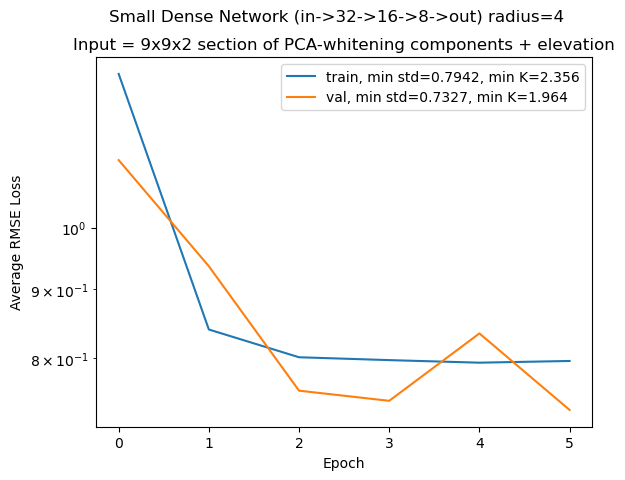

radius=4, n_components=3
 ToyModel(
  (linear1): Linear(in_features=324, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.3349,  3.9598   	 Val (RMSE, K):  1.2782,  3.4261   	LR:  0.001	Time: 24.8
Epoch 001:     Train (RMSE, K):  0.88352,  2.6207   	 Val (RMSE, K):  0.97294,  2.6079   	LR:  0.001	Time: 25.4
Epoch 002:     Train (RMSE, K):  0.79925,  2.3708   	 Val (RMSE, K):  0.93268,     2.5   	LR:  0.001	Time: 25.4
Epoch 003:     Train (RMSE, K):  0.78441,  2.3267   	 Val (RMSE, K):  1.0797,   2.894   	LR:  0.001	Time: 25.5
Epoch 004:     Train (RMSE, K):  0.78336,  2.3236   	 Val (RMSE, K):  1.0052,  2.6943   	LR:  0.001	Time: 25.1
Epoch 005:     Train (RMSE, K):  0.78095,  2.3165   	 Val (RMSE, K):  0.88899,  2.3829   	LR:  0.001	Time: 25.5


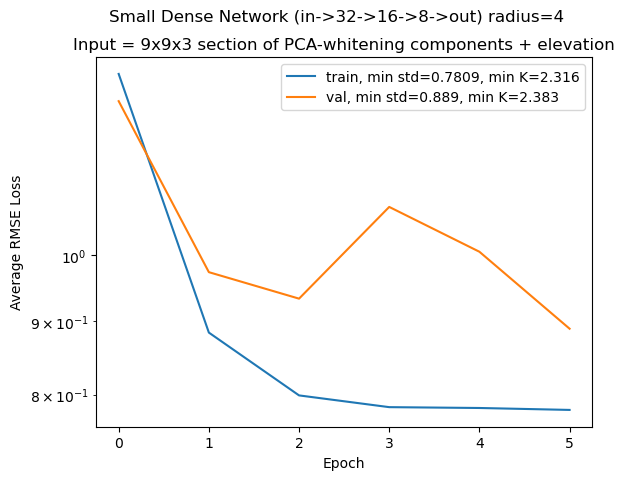

radius=4, n_components=4
 ToyModel(
  (linear1): Linear(in_features=405, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.3316,    3.95   	 Val (RMSE, K):  1.1853,  3.1771   	LR:  0.001	Time: 25.0
Epoch 001:     Train (RMSE, K):  0.81476,  2.4167   	 Val (RMSE, K):  0.90427,  2.4238   	LR:  0.001	Time: 25.3
Epoch 002:     Train (RMSE, K):  0.8057,  2.3899   	 Val (RMSE, K):  1.0546,  2.8268   	LR:  0.001	Time: 25.3
Epoch 003:     Train (RMSE, K):  0.78332,  2.3235   	 Val (RMSE, K):  1.0195,  2.7326   	LR:  0.001	Time: 25.6
Epoch 004:     Train (RMSE, K):  0.78354,  2.3241   	 Val (RMSE, K):  0.90014,  2.4128   	LR:  0.001	Time: 25.4
Epoch 005:     Train (RMSE, K):  0.78308,  2.3228   	 Val (RMSE, K):  0.8665,  2.3226   	LR:  0.001	Time: 25.7


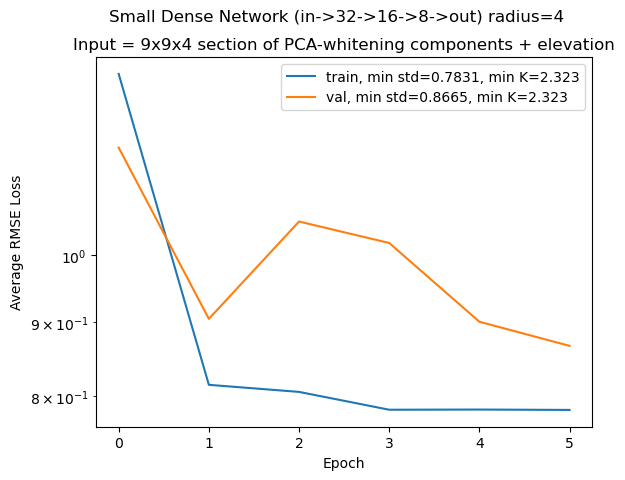

radius=4, n_components=5
 ToyModel(
  (linear1): Linear(in_features=486, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.4076,  4.1751   	 Val (RMSE, K):  1.3294,  3.5634   	LR:  0.001	Time: 24.9
Epoch 001:     Train (RMSE, K):  1.0028,  2.9746   	 Val (RMSE, K):  0.92449,   2.478   	LR:  0.001	Time: 25.6
Epoch 002:     Train (RMSE, K):  0.81225,  2.4093   	 Val (RMSE, K):  0.97551,  2.6148   	LR:  0.001	Time: 25.9
Epoch 003:     Train (RMSE, K):  0.79497,  2.3581   	 Val (RMSE, K):  0.84989,  2.2781   	LR:  0.001	Time: 25.7
Epoch 004:     Train (RMSE, K):  0.79187,  2.3489   	 Val (RMSE, K):  0.96001,  2.5732   	LR:  0.001	Time: 25.7
Epoch 005:     Train (RMSE, K):  0.78568,  2.3305   	 Val (RMSE, K):  0.82029,  2.1987   	LR:  0.001	Time: 25.8


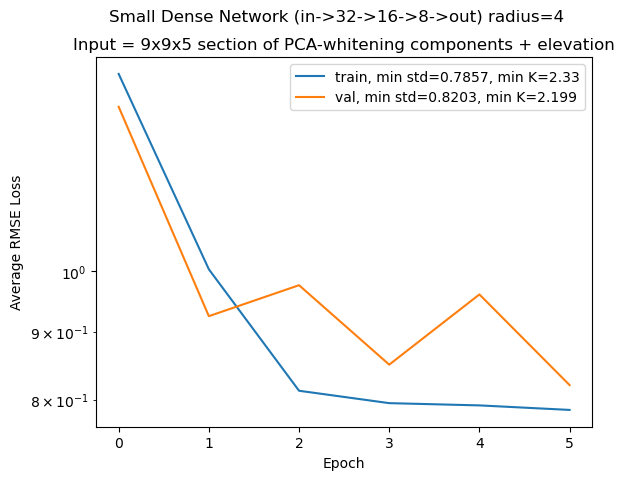

radius=4, n_components=6
 ToyModel(
  (linear1): Linear(in_features=567, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  0.99601,  2.9544   	 Val (RMSE, K):  1.1051,  2.9621   	LR:  0.001	Time: 25.0
Epoch 001:     Train (RMSE, K):  0.82933,    2.46   	 Val (RMSE, K):  1.0344,  2.7726   	LR:  0.001	Time: 26.3
Epoch 002:     Train (RMSE, K):  0.80737,  2.3949   	 Val (RMSE, K):   1.002,  2.6858   	LR:  0.001	Time: 26.0
Epoch 003:     Train (RMSE, K):  0.79983,  2.3725   	 Val (RMSE, K):  0.90569,  2.4276   	LR:  0.001	Time: 26.2
Epoch 004:     Train (RMSE, K):  0.78659,  2.3332   	 Val (RMSE, K):  1.0982,  2.9436   	LR:  0.001	Time: 26.2
Epoch 005:     Train (RMSE, K):  0.78467,  2.3275   	 Val (RMSE, K):  1.0505,  2.8159   	LR:  0.001	Time: 26.3


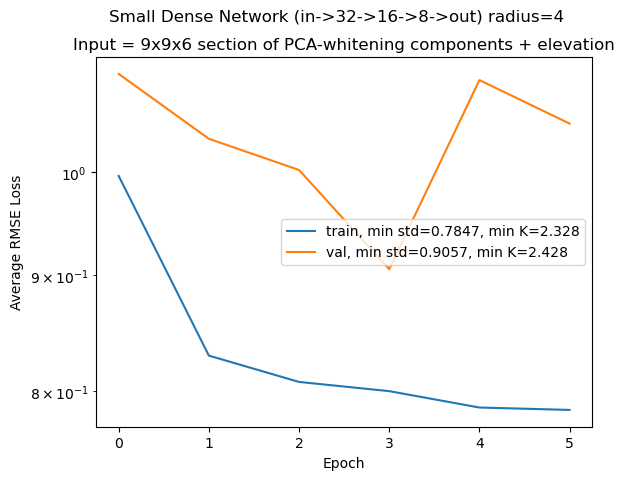

radius=4, n_components=7
 ToyModel(
  (linear1): Linear(in_features=648, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.0024,  2.9732   	 Val (RMSE, K):  0.91729,  2.4587   	LR:  0.001	Time: 25.1
Epoch 001:     Train (RMSE, K):    0.82,  2.4323   	 Val (RMSE, K):  0.79392,   2.128   	LR:  0.001	Time: 26.4
Epoch 002:     Train (RMSE, K):   0.783,  2.3226   	 Val (RMSE, K):  0.8367,  2.2427   	LR:  0.001	Time: 26.3
Epoch 003:     Train (RMSE, K):  0.77734,  2.3058   	 Val (RMSE, K):  0.86764,  2.3256   	LR:  0.001	Time: 26.0
Epoch 004:     Train (RMSE, K):  0.78529,  2.3293   	 Val (RMSE, K):  0.86874,  2.3286   	LR:  0.001	Time: 26.3
Epoch 005:     Train (RMSE, K):  0.78706,  2.3346   	 Val (RMSE, K):  0.83651,  2.2422   	LR: 0.0002	Time: 26.4


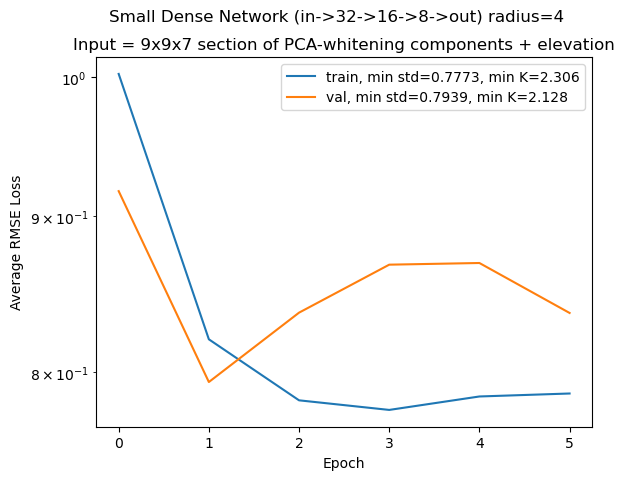

radius=4, n_components=8
 ToyModel(
  (linear1): Linear(in_features=729, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.3119,  3.8914   	 Val (RMSE, K):  1.1768,  3.1544   	LR:  0.001	Time: 25.2
Epoch 001:     Train (RMSE, K):  1.0025,  2.9737   	 Val (RMSE, K):  0.89609,  2.4019   	LR:  0.001	Time: 26.6
Epoch 002:     Train (RMSE, K):  0.88323,  2.6199   	 Val (RMSE, K):  0.75936,  2.0354   	LR:  0.001	Time: 26.6
Epoch 003:     Train (RMSE, K):  0.79334,  2.3532   	 Val (RMSE, K):  0.9207,  2.4679   	LR:  0.001	Time: 26.5
Epoch 004:     Train (RMSE, K):  0.76784,  2.2776   	 Val (RMSE, K):  0.93213,  2.4985   	LR:  0.001	Time: 26.5
Epoch 005:     Train (RMSE, K):  0.7691,  2.2813   	 Val (RMSE, K):  0.80131,  2.1479   	LR:  0.001	Time: 26.5


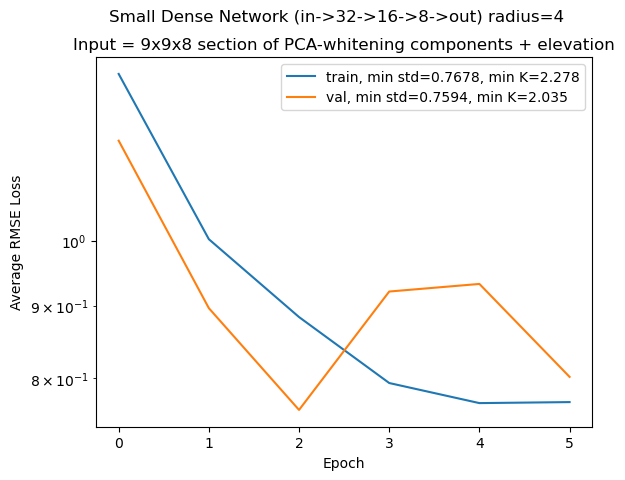

radius=5, n_components=2
 ToyModel(
  (linear1): Linear(in_features=363, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.5308,  4.5408   	 Val (RMSE, K):  1.2638,  3.3875   	LR:  0.001	Time: 27.7
Epoch 001:     Train (RMSE, K):  0.83152,  2.4665   	 Val (RMSE, K):  0.7598,  2.0366   	LR:  0.001	Time: 29.2
Epoch 002:     Train (RMSE, K):  0.80449,  2.3863   	 Val (RMSE, K):  0.71358,  1.9127   	LR:  0.001	Time: 29.5
Epoch 003:     Train (RMSE, K):  0.80296,  2.3817   	 Val (RMSE, K):  0.86235,  2.3115   	LR:  0.001	Time: 29.5
Epoch 004:     Train (RMSE, K):  0.80047,  2.3744   	 Val (RMSE, K):  0.89184,  2.3905   	LR:  0.001	Time: 29.4
Epoch 005:     Train (RMSE, K):  0.7999,  2.3727   	 Val (RMSE, K):  0.77764,  2.0844   	LR:  0.001	Time: 29.7


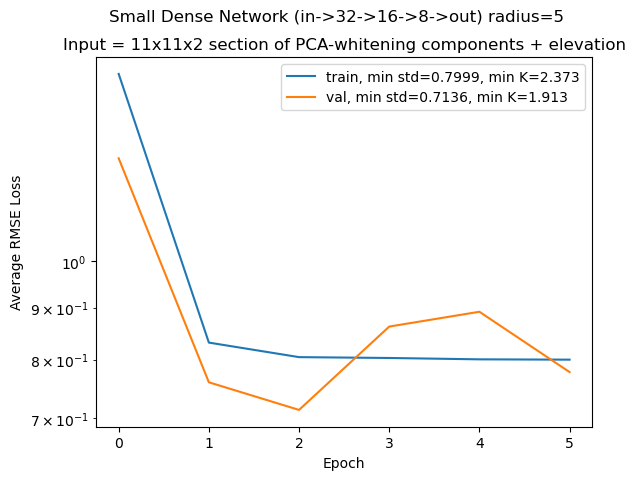

radius=5, n_components=3
 ToyModel(
  (linear1): Linear(in_features=484, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.4543,  4.3137   	 Val (RMSE, K):  1.3649,  3.6586   	LR:  0.001	Time: 28.4
Epoch 001:     Train (RMSE, K):  0.87598,  2.5984   	 Val (RMSE, K):  0.83399,  2.2354   	LR:  0.001	Time: 29.8
Epoch 002:     Train (RMSE, K):  0.7874,  2.3356   	 Val (RMSE, K):  0.91262,  2.4462   	LR:  0.001	Time: 29.3
Epoch 003:     Train (RMSE, K):  0.78982,  2.3428   	 Val (RMSE, K):  0.78313,  2.0991   	LR:  0.001	Time: 29.7
Epoch 004:     Train (RMSE, K):  0.7826,  2.3214   	 Val (RMSE, K):  0.77874,  2.0874   	LR:  0.001	Time: 29.4
Epoch 005:     Train (RMSE, K):  0.78395,  2.3254   	 Val (RMSE, K):  0.78766,  2.1113   	LR:  0.001	Time: 30.2


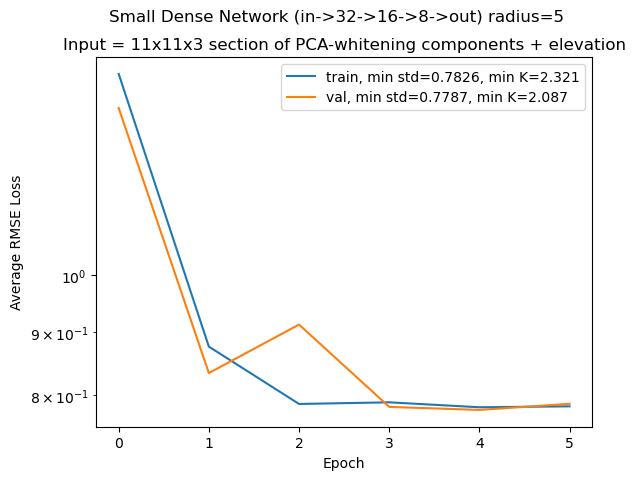

radius=5, n_components=4
 ToyModel(
  (linear1): Linear(in_features=605, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1759,   3.488   	 Val (RMSE, K):  0.98769,  2.6474   	LR:  0.001	Time: 28.6
Epoch 001:     Train (RMSE, K):  0.86408,  2.5631   	 Val (RMSE, K):  0.95113,  2.5494   	LR:  0.001	Time: 29.8
Epoch 002:     Train (RMSE, K):  0.79108,  2.3465   	 Val (RMSE, K):  1.0354,  2.7753   	LR:  0.001	Time: 29.9
Epoch 003:     Train (RMSE, K):  0.78934,  2.3414   	 Val (RMSE, K):  0.75331,  2.0192   	LR:  0.001	Time: 29.9
Epoch 004:     Train (RMSE, K):  0.79316,  2.3527   	 Val (RMSE, K):  1.0206,  2.7358   	LR:  0.001	Time: 29.5
Epoch 005:     Train (RMSE, K):  0.78889,    2.34   	 Val (RMSE, K):  1.0074,  2.7004   	LR:  0.001	Time: 29.9


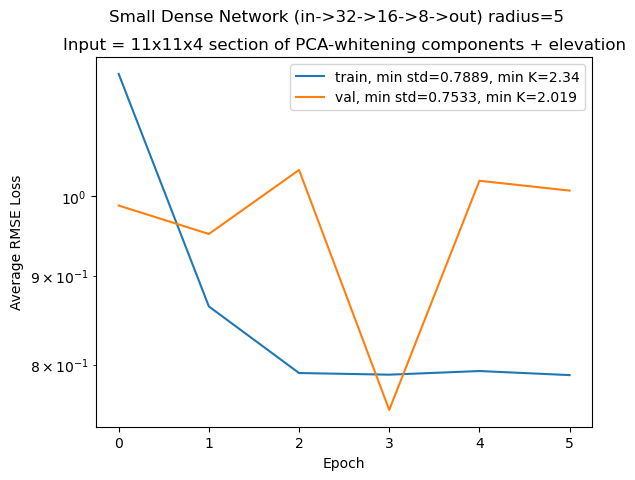

radius=5, n_components=5
 ToyModel(
  (linear1): Linear(in_features=726, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.6156,  4.7923   	 Val (RMSE, K):  1.3612,  3.6486   	LR:  0.001	Time: 29.1
Epoch 001:     Train (RMSE, K):  0.91455,  2.7128   	 Val (RMSE, K):  0.79361,  2.1272   	LR:  0.001	Time: 30.5
Epoch 002:     Train (RMSE, K):  0.79595,   2.361   	 Val (RMSE, K):  0.78302,  2.0988   	LR:  0.001	Time: 30.3
Epoch 003:     Train (RMSE, K):  0.78844,  2.3387   	 Val (RMSE, K):  0.86191,  2.3103   	LR:  0.001	Time: 30.3
Epoch 004:     Train (RMSE, K):  0.79062,  2.3452   	 Val (RMSE, K):  0.83418,  2.2359   	LR:  0.001	Time: 30.5
Epoch 005:     Train (RMSE, K):  0.78545,  2.3298   	 Val (RMSE, K):  0.89322,  2.3942   	LR:  0.001	Time: 30.4


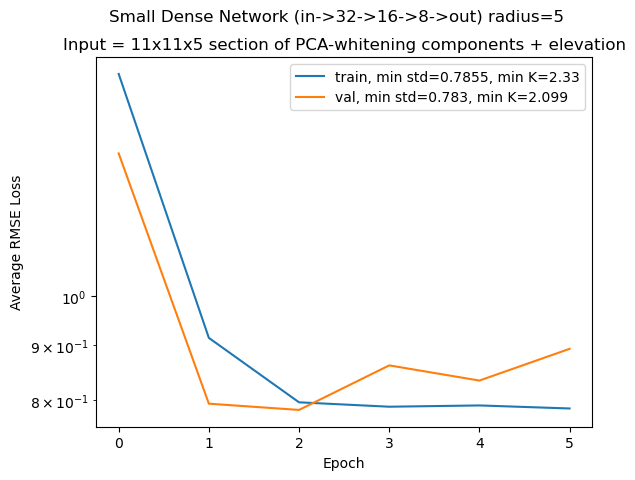

radius=5, n_components=6
 ToyModel(
  (linear1): Linear(in_features=847, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1327,  3.3598   	 Val (RMSE, K):  1.0182,  2.7293   	LR:  0.001	Time: 29.2
Epoch 001:     Train (RMSE, K):  0.8162,   2.421   	 Val (RMSE, K):  0.9697,  2.5992   	LR:  0.001	Time: 30.6
Epoch 002:     Train (RMSE, K):  0.78219,  2.3201   	 Val (RMSE, K):  0.99491,  2.6668   	LR:  0.001	Time: 30.7
Epoch 003:     Train (RMSE, K):  0.78298,  2.3225   	 Val (RMSE, K):  0.82529,  2.2121   	LR:  0.001	Time: 30.6
Epoch 004:     Train (RMSE, K):  0.78541,  2.3297   	 Val (RMSE, K):  0.96508,  2.5868   	LR:  0.001	Time: 30.5
Epoch 005:     Train (RMSE, K):  0.78049,  2.3151   	 Val (RMSE, K):  0.84448,  2.2636   	LR:  0.001	Time: 30.7


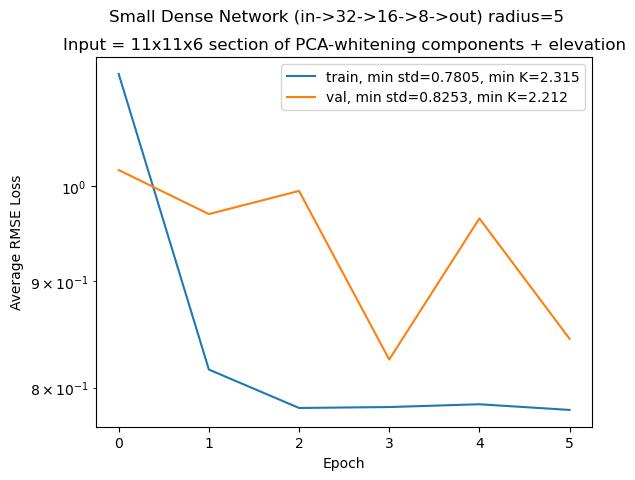

radius=5, n_components=7
 ToyModel(
  (linear1): Linear(in_features=968, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.0027,  2.9743   	 Val (RMSE, K):  0.92357,  2.4756   	LR:  0.001	Time: 29.5
Epoch 001:     Train (RMSE, K):  0.84298,  2.5005   	 Val (RMSE, K):  0.7846,  2.1031   	LR:  0.001	Time: 30.6
Epoch 002:     Train (RMSE, K):  0.80107,  2.3762   	 Val (RMSE, K):  0.9517,   2.551   	LR:  0.001	Time: 30.5
Epoch 003:     Train (RMSE, K):  0.78782,  2.3368   	 Val (RMSE, K):  0.95255,  2.5532   	LR:  0.001	Time: 30.8
Epoch 004:     Train (RMSE, K):  0.77651,  2.3033   	 Val (RMSE, K):  0.93414,  2.5039   	LR:  0.001	Time: 30.7
Epoch 005:     Train (RMSE, K):  0.77111,  2.2873   	 Val (RMSE, K):  0.90638,  2.4295   	LR: 0.0002	Time: 30.7


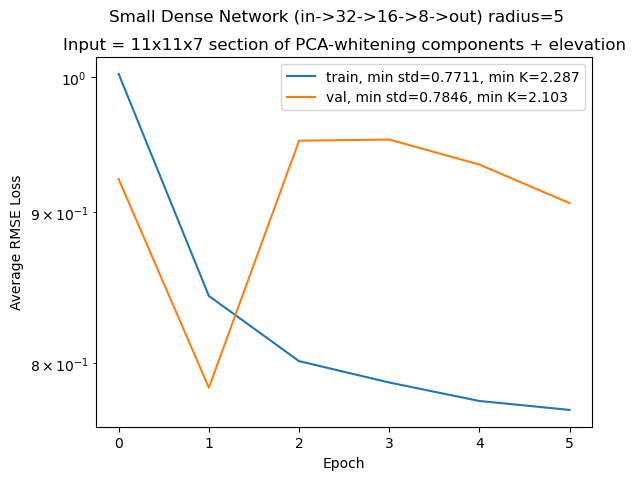

radius=5, n_components=8
 ToyModel(
  (linear1): Linear(in_features=1089, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.5127,   4.487   	 Val (RMSE, K):  1.3071,  3.5037   	LR:  0.001	Time: 30.1
Epoch 001:     Train (RMSE, K):  0.84642,  2.5107   	 Val (RMSE, K):  0.74517,  1.9974   	LR:  0.001	Time: 31.2
Epoch 002:     Train (RMSE, K):  0.77662,  2.3036   	 Val (RMSE, K):  0.89289,  2.3933   	LR:  0.001	Time: 31.1
Epoch 003:     Train (RMSE, K):  0.7852,  2.3291   	 Val (RMSE, K):  0.96753,  2.5934   	LR:  0.001	Time: 31.0
Epoch 004:     Train (RMSE, K):  0.77221,  2.2905   	 Val (RMSE, K):  0.82371,  2.2079   	LR:  0.001	Time: 31.0
Epoch 005:     Train (RMSE, K):  0.7653,  2.2701   	 Val (RMSE, K):  0.81286,  2.1788   	LR: 0.0002	Time: 31.4


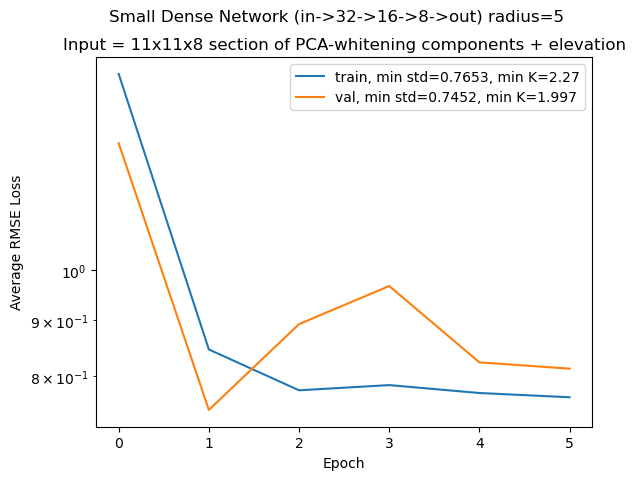

radius=6, n_components=2
 ToyModel(
  (linear1): Linear(in_features=507, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.3109,  3.8886   	 Val (RMSE, K):  0.98179,  2.6316   	LR:  0.001	Time: 33.0
Epoch 001:     Train (RMSE, K):  0.88767,   2.633   	 Val (RMSE, K):  0.76056,  2.0386   	LR:  0.001	Time: 34.0
Epoch 002:     Train (RMSE, K):  0.80278,  2.3812   	 Val (RMSE, K):  0.80326,  2.1531   	LR:  0.001	Time: 34.2
Epoch 003:     Train (RMSE, K):  0.80605,  2.3909   	 Val (RMSE, K):  0.80182,  2.1492   	LR:  0.001	Time: 34.2
Epoch 004:     Train (RMSE, K):  0.80337,   2.383   	 Val (RMSE, K):  0.83307,   2.233   	LR:  0.001	Time: 33.8
Epoch 005:     Train (RMSE, K):  0.80364,  2.3838   	 Val (RMSE, K):  0.78461,  2.1031   	LR: 0.0002	Time: 33.9


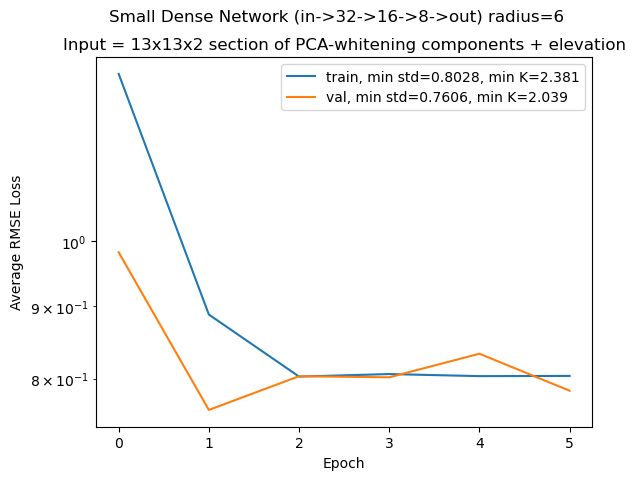

radius=6, n_components=3
 ToyModel(
  (linear1): Linear(in_features=676, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2423,  3.6851   	 Val (RMSE, K):  1.1252,  3.0159   	LR:  0.001	Time: 32.9
Epoch 001:     Train (RMSE, K):  0.89793,  2.6635   	 Val (RMSE, K):  0.85016,  2.2788   	LR:  0.001	Time: 34.1
Epoch 002:     Train (RMSE, K):  0.78908,  2.3406   	 Val (RMSE, K):  0.84564,  2.2667   	LR:  0.001	Time: 34.5
Epoch 003:     Train (RMSE, K):  0.7841,  2.3258   	 Val (RMSE, K):  0.82682,  2.2162   	LR:  0.001	Time: 34.5
Epoch 004:     Train (RMSE, K):  0.78424,  2.3262   	 Val (RMSE, K):  1.0001,  2.6807   	LR:  0.001	Time: 34.5
Epoch 005:     Train (RMSE, K):  0.78354,  2.3241   	 Val (RMSE, K):  0.82098,  2.2006   	LR:  0.001	Time: 34.2


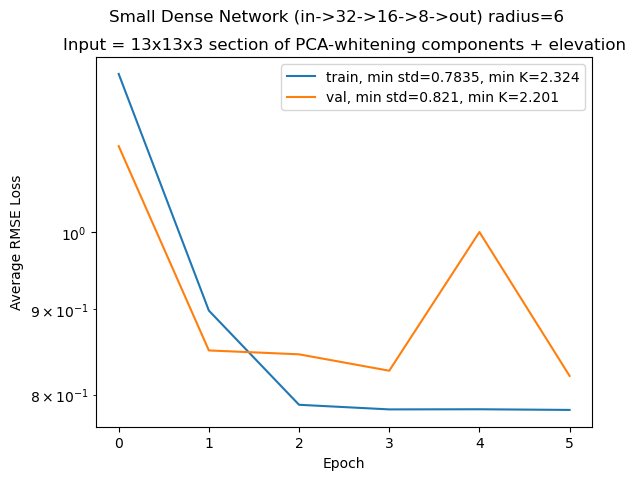

radius=6, n_components=4
 ToyModel(
  (linear1): Linear(in_features=845, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.5788,  4.6832   	 Val (RMSE, K):  1.2944,  3.4696   	LR:  0.001	Time: 33.3
Epoch 001:     Train (RMSE, K):     0.9,  2.6696   	 Val (RMSE, K):  1.0896,  2.9206   	LR:  0.001	Time: 35.0
Epoch 002:     Train (RMSE, K):  0.79619,  2.3617   	 Val (RMSE, K):  0.86251,  2.3119   	LR:  0.001	Time: 35.1
Epoch 003:     Train (RMSE, K):  0.8145,   2.416   	 Val (RMSE, K):  0.94745,  2.5396   	LR:  0.001	Time: 35.0
Epoch 004:     Train (RMSE, K):  0.79615,  2.3615   	 Val (RMSE, K):   1.034,  2.7714   	LR:  0.001	Time: 34.6
Epoch 005:     Train (RMSE, K):  0.79822,  2.3677   	 Val (RMSE, K):  1.1155,  2.9901   	LR:  0.001	Time: 35.0


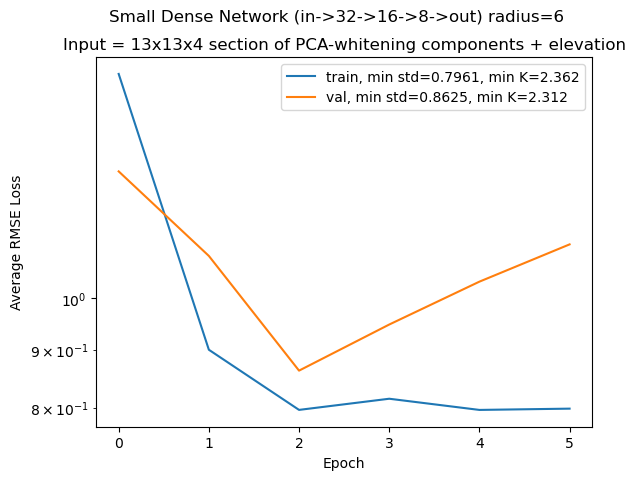

radius=6, n_components=5
 ToyModel(
  (linear1): Linear(in_features=1014, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2167,  3.6091   	 Val (RMSE, K):  1.0233,   2.743   	LR:  0.001	Time: 33.7
Epoch 001:     Train (RMSE, K):  0.90513,  2.6848   	 Val (RMSE, K):  0.73775,  1.9775   	LR:  0.001	Time: 35.3
Epoch 002:     Train (RMSE, K):  0.82749,  2.4545   	 Val (RMSE, K):  0.75812,  2.0321   	LR:  0.001	Time: 35.1
Epoch 003:     Train (RMSE, K):  0.81934,  2.4303   	 Val (RMSE, K):  0.8006,   2.146   	LR:  0.001	Time: 35.4
Epoch 004:     Train (RMSE, K):  0.81495,  2.4173   	 Val (RMSE, K):  0.90305,  2.4205   	LR:  0.001	Time: 35.1
Epoch 005:     Train (RMSE, K):  0.8188,  2.4287   	 Val (RMSE, K):  0.94159,  2.5239   	LR: 0.0002	Time: 35.0


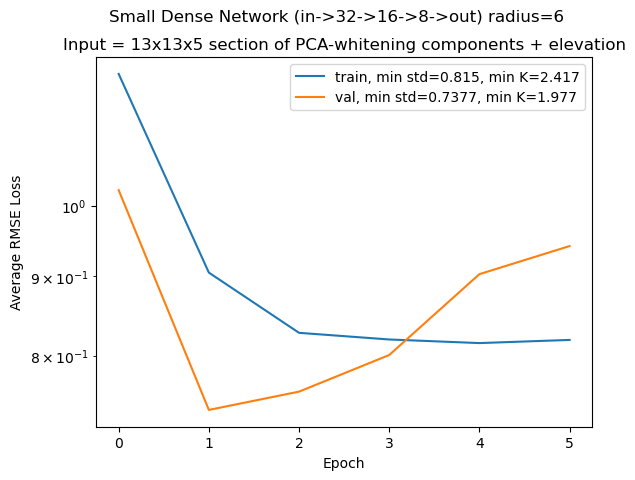

radius=6, n_components=6
 ToyModel(
  (linear1): Linear(in_features=1183, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2888,   3.823   	 Val (RMSE, K):  1.1641,  3.1202   	LR:  0.001	Time: 34.1
Epoch 001:     Train (RMSE, K):  0.81272,  2.4107   	 Val (RMSE, K):  0.77629,  2.0808   	LR:  0.001	Time: 35.4
Epoch 002:     Train (RMSE, K):  0.81873,  2.4286   	 Val (RMSE, K):  0.91857,  2.4622   	LR:  0.001	Time: 35.4
Epoch 003:     Train (RMSE, K):  0.81869,  2.4284   	 Val (RMSE, K):  0.91845,  2.4618   	LR:  0.001	Time: 36.0
Epoch 004:     Train (RMSE, K):  0.77904,  2.3108   	 Val (RMSE, K):  0.76484,  2.0501   	LR:  0.001	Time: 36.0
Epoch 005:     Train (RMSE, K):  0.78146,   2.318   	 Val (RMSE, K):  1.0211,  2.7369   	LR:  0.001	Time: 36.0


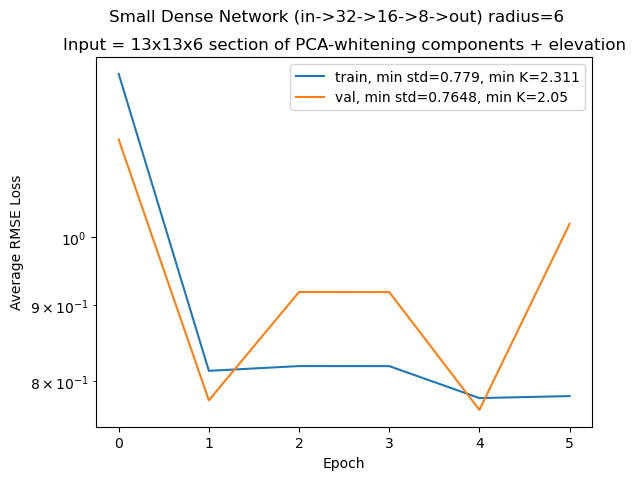

radius=6, n_components=7
 ToyModel(
  (linear1): Linear(in_features=1352, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.5963,  4.7349   	 Val (RMSE, K):  1.2351,  3.3106   	LR:  0.001	Time: 35.0
Epoch 001:     Train (RMSE, K):  0.92407,   2.741   	 Val (RMSE, K):  0.72319,  1.9385   	LR:  0.001	Time: 36.2
Epoch 002:     Train (RMSE, K):  0.79577,  2.3604   	 Val (RMSE, K):  0.72726,  1.9494   	LR:  0.001	Time: 35.7
Epoch 003:     Train (RMSE, K):  0.77912,   2.311   	 Val (RMSE, K):  0.71075,  1.9051   	LR:  0.001	Time: 35.9
Epoch 004:     Train (RMSE, K):  0.78467,  2.3275   	 Val (RMSE, K):  0.73242,  1.9632   	LR:  0.001	Time: 35.9
Epoch 005:     Train (RMSE, K):  0.7768,  2.3042   	 Val (RMSE, K):  0.76332,   2.046   	LR:  0.001	Time: 35.8


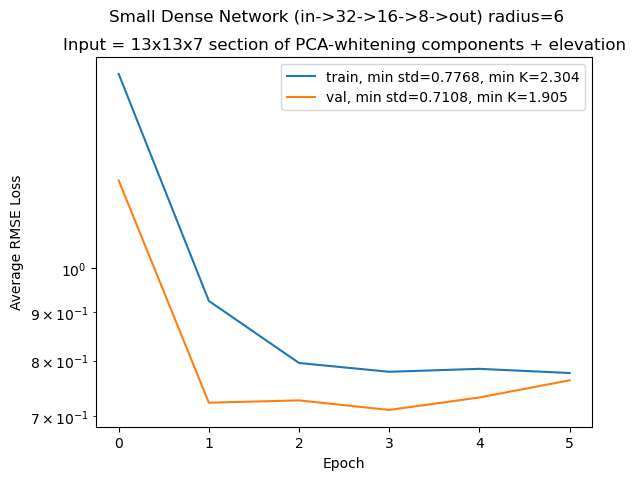

radius=6, n_components=8
 ToyModel(
  (linear1): Linear(in_features=1521, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2399,  3.6777   	 Val (RMSE, K):  1.2214,  3.2738   	LR:  0.001	Time: 34.4
Epoch 001:     Train (RMSE, K):  0.88287,  2.6188   	 Val (RMSE, K):  0.9124,  2.4456   	LR:  0.001	Time: 35.7
Epoch 002:     Train (RMSE, K):  0.78071,  2.3158   	 Val (RMSE, K):  0.83366,  2.2346   	LR:  0.001	Time: 35.7
Epoch 003:     Train (RMSE, K):  0.77008,  2.2842   	 Val (RMSE, K):  0.80622,   2.161   	LR:  0.001	Time: 35.3
Epoch 004:     Train (RMSE, K):  0.76837,  2.2792   	 Val (RMSE, K):  0.77049,  2.0652   	LR:  0.001	Time: 35.8
Epoch 005:     Train (RMSE, K):  0.76995,  2.2838   	 Val (RMSE, K):  0.79787,  2.1386   	LR:  0.001	Time: 36.0


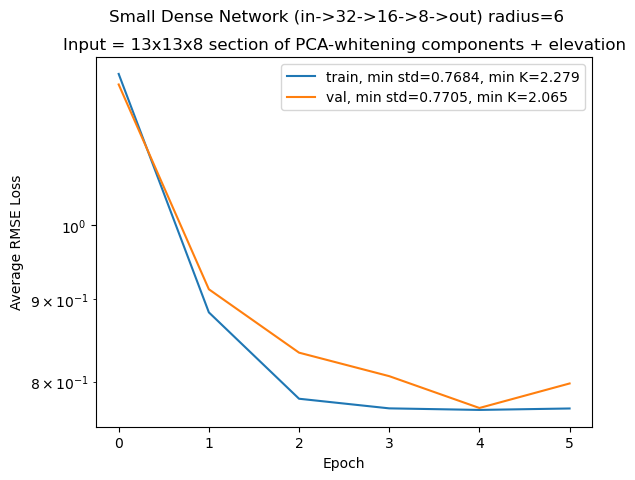

radius=8, n_components=2
 ToyModel(
  (linear1): Linear(in_features=867, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  0.99168,  2.9415   	 Val (RMSE, K):   1.354,  3.6293   	LR:  0.001	Time: 42.2
Epoch 001:     Train (RMSE, K):  0.84116,  2.4951   	 Val (RMSE, K):  0.93808,  2.5145   	LR:  0.001	Time: 43.3
Epoch 002:     Train (RMSE, K):  0.80901,  2.3997   	 Val (RMSE, K):  0.83138,  2.2284   	LR:  0.001	Time: 43.5
Epoch 003:     Train (RMSE, K):  0.80598,  2.3907   	 Val (RMSE, K):  0.97901,  2.6242   	LR:  0.001	Time: 43.4
Epoch 004:     Train (RMSE, K):   0.799,    2.37   	 Val (RMSE, K):  0.84698,  2.2703   	LR:  0.001	Time: 43.6
Epoch 005:     Train (RMSE, K):  0.8011,  2.3762   	 Val (RMSE, K):  0.83581,  2.2403   	LR:  0.001	Time: 43.6


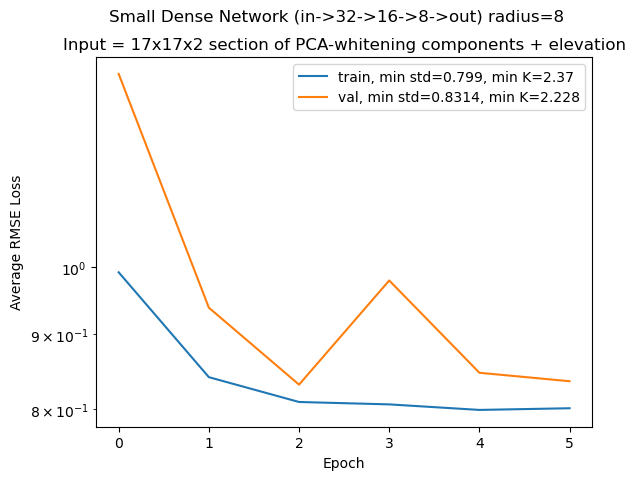

radius=8, n_components=3
 ToyModel(
  (linear1): Linear(in_features=1156, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.3447,  3.9887   	 Val (RMSE, K):  1.4293,   3.831   	LR:  0.001	Time: 43.5
Epoch 001:     Train (RMSE, K):  0.83488,  2.4764   	 Val (RMSE, K):  0.82304,  2.2061   	LR:  0.001	Time: 44.4
Epoch 002:     Train (RMSE, K):  0.79808,  2.3673   	 Val (RMSE, K):  0.74753,  2.0037   	LR:  0.001	Time: 44.4
Epoch 003:     Train (RMSE, K):  0.79051,  2.3448   	 Val (RMSE, K):  0.92356,  2.4755   	LR:  0.001	Time: 44.6
Epoch 004:     Train (RMSE, K):  0.78816,  2.3379   	 Val (RMSE, K):  0.77422,  2.0752   	LR:  0.001	Time: 44.6
Epoch 005:     Train (RMSE, K):  0.78751,  2.3359   	 Val (RMSE, K):  0.81763,  2.1916   	LR:  0.001	Time: 44.9


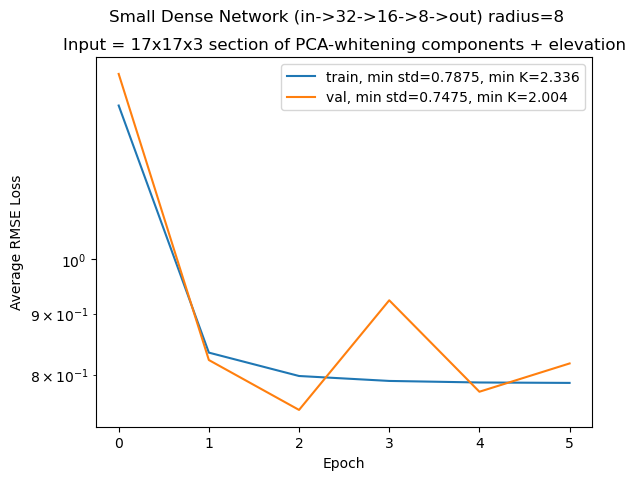

radius=8, n_components=4
 ToyModel(
  (linear1): Linear(in_features=1445, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.0921,  3.2394   	 Val (RMSE, K):  0.85949,  2.3038   	LR:  0.001	Time: 43.8
Epoch 001:     Train (RMSE, K):  0.90785,  2.6929   	 Val (RMSE, K):  0.75378,  2.0205   	LR:  0.001	Time: 45.4
Epoch 002:     Train (RMSE, K):  0.84861,  2.5172   	 Val (RMSE, K):  0.76887,  2.0609   	LR:  0.001	Time: 45.4
Epoch 003:     Train (RMSE, K):   0.848,  2.5154   	 Val (RMSE, K):  0.89933,  2.4106   	LR:  0.001	Time: 45.6
Epoch 004:     Train (RMSE, K):  0.83674,  2.4819   	 Val (RMSE, K):   1.265,  3.3907   	LR:  0.001	Time: 45.8
Epoch 005:     Train (RMSE, K):  0.82995,  2.4618   	 Val (RMSE, K):  1.2681,   3.399   	LR: 0.0002	Time: 45.8


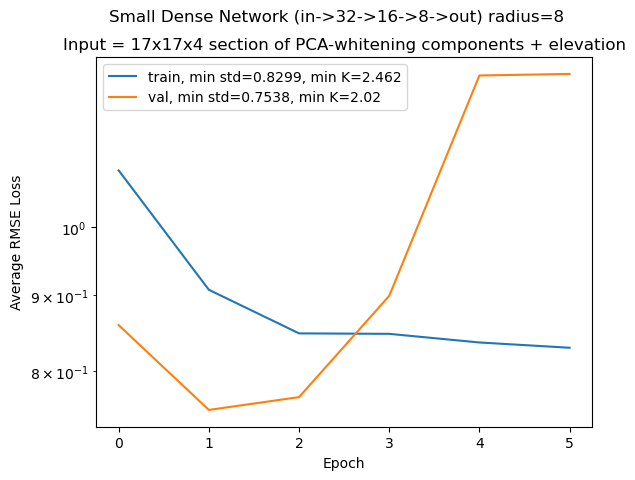

radius=8, n_components=5
 ToyModel(
  (linear1): Linear(in_features=1734, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1478,  3.4047   	 Val (RMSE, K):  0.91875,  2.4626   	LR:  0.001	Time: 44.7
Epoch 001:     Train (RMSE, K):  0.93439,  2.7716   	 Val (RMSE, K):  0.71994,  1.9297   	LR:  0.001	Time: 45.8
Epoch 002:     Train (RMSE, K):  0.8319,  2.4676   	 Val (RMSE, K):  0.8512,  2.2816   	LR:  0.001	Time: 45.8
Epoch 003:     Train (RMSE, K):  0.82436,  2.4452   	 Val (RMSE, K):  0.96066,   2.575   	LR:  0.001	Time: 46.0
Epoch 004:     Train (RMSE, K):  0.81904,  2.4294   	 Val (RMSE, K):  1.0535,  2.8238   	LR:  0.001	Time: 46.0
Epoch 005:     Train (RMSE, K):  0.82384,  2.4437   	 Val (RMSE, K):  1.0754,  2.8826   	LR: 0.0002	Time: 46.2


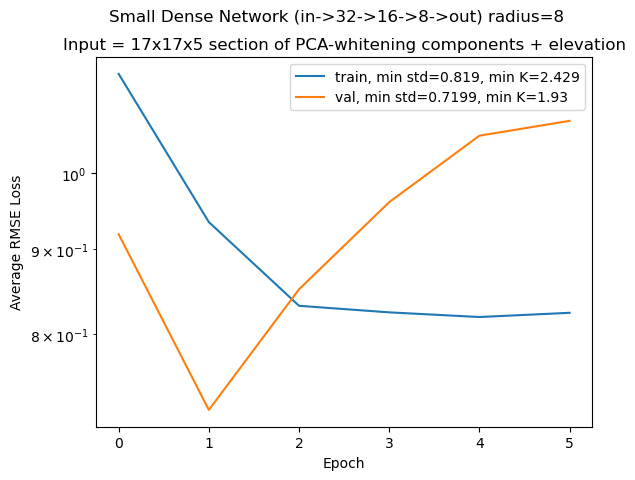

radius=8, n_components=6
 ToyModel(
  (linear1): Linear(in_features=2023, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2854,  3.8129   	 Val (RMSE, K):  1.2088,    3.24   	LR:  0.001	Time: 45.4
Epoch 001:     Train (RMSE, K):  0.84737,  2.5135   	 Val (RMSE, K):  0.79068,  2.1194   	LR:  0.001	Time: 46.6
Epoch 002:     Train (RMSE, K):  0.80671,  2.3929   	 Val (RMSE, K):  0.96601,  2.5893   	LR:  0.001	Time: 46.7
Epoch 003:     Train (RMSE, K):  0.78363,  2.3244   	 Val (RMSE, K):  0.85995,   2.305   	LR:  0.001	Time: 46.9
Epoch 004:     Train (RMSE, K):  0.78396,  2.3254   	 Val (RMSE, K):  0.97539,  2.6145   	LR:  0.001	Time: 46.7
Epoch 005:     Train (RMSE, K):  0.7878,  2.3368   	 Val (RMSE, K):  0.95246,   2.553   	LR: 0.0002	Time: 47.1


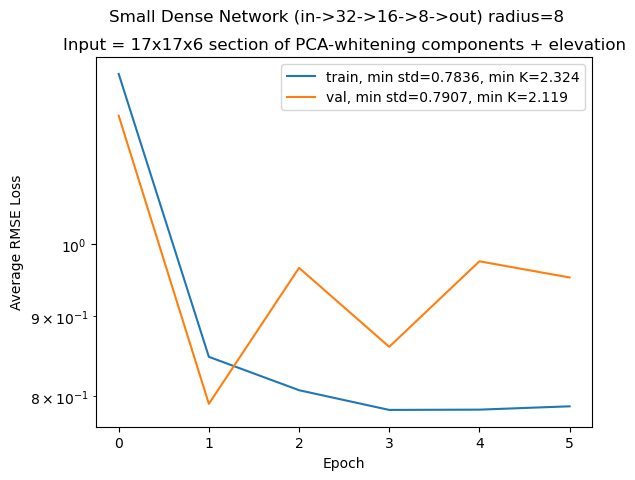

radius=8, n_components=7
 ToyModel(
  (linear1): Linear(in_features=2312, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2553,  3.7235   	 Val (RMSE, K):  1.0422,  2.7937   	LR:  0.001	Time: 44.6
Epoch 001:     Train (RMSE, K):  0.8887,  2.6361   	 Val (RMSE, K):  0.74284,  1.9911   	LR:  0.001	Time: 46.1
Epoch 002:     Train (RMSE, K):  0.79738,  2.3652   	 Val (RMSE, K):  0.82747,   2.218   	LR:  0.001	Time: 46.0
Epoch 003:     Train (RMSE, K):  0.7902,  2.3439   	 Val (RMSE, K):  0.92782,   2.487   	LR:  0.001	Time: 45.7
Epoch 004:     Train (RMSE, K):  0.78134,  2.3176   	 Val (RMSE, K):  0.75377,  2.0204   	LR:  0.001	Time: 46.1
Epoch 005:     Train (RMSE, K):  0.77694,  2.3046   	 Val (RMSE, K):  0.76311,  2.0454   	LR: 0.0002	Time: 46.1


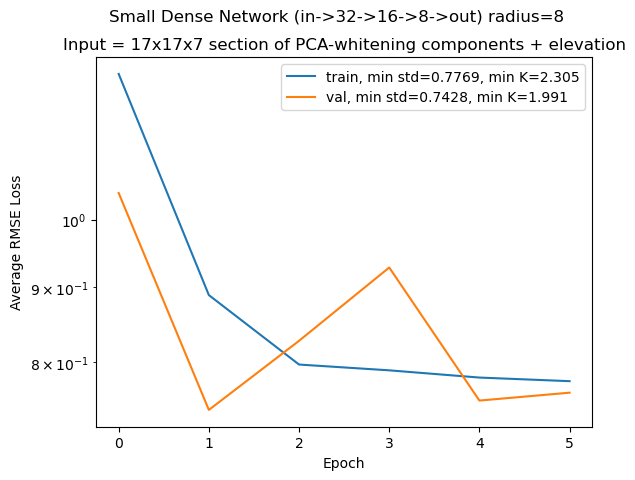

radius=8, n_components=8
 ToyModel(
  (linear1): Linear(in_features=2601, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.4191,  4.2094   	 Val (RMSE, K):  1.5585,  4.1774   	LR:  0.001	Time: 45.8
Epoch 001:     Train (RMSE, K):  0.8248,  2.4465   	 Val (RMSE, K):  0.86075,  2.3072   	LR:  0.001	Time: 47.0
Epoch 002:     Train (RMSE, K):  0.78455,  2.3272   	 Val (RMSE, K):  0.98409,  2.6378   	LR:  0.001	Time: 46.7
Epoch 003:     Train (RMSE, K):  0.78212,  2.3199   	 Val (RMSE, K):  0.87645,  2.3493   	LR:  0.001	Time: 46.6
Epoch 004:     Train (RMSE, K):  0.76874,  2.2802   	 Val (RMSE, K):  0.92847,  2.4887   	LR:  0.001	Time: 46.5
Epoch 005:     Train (RMSE, K):  0.76726,  2.2759   	 Val (RMSE, K):  0.93427,  2.5042   	LR: 0.0002	Time: 46.9


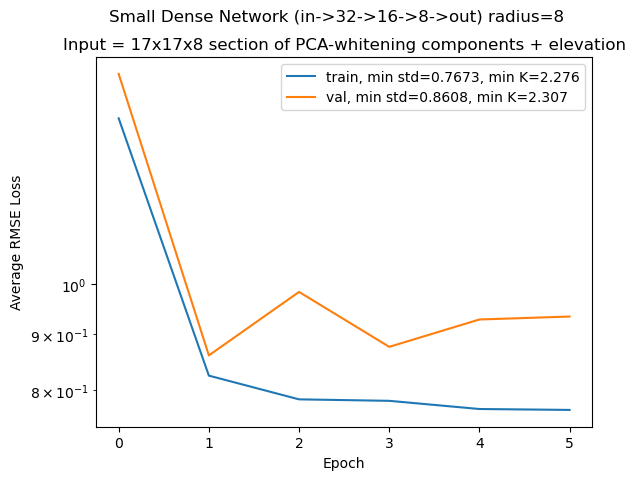

radius=10, n_components=2
 ToyModel(
  (linear1): Linear(in_features=1323, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.1036,  3.2735   	 Val (RMSE, K):  0.98675,  2.6449   	LR:  0.001	Time: 55.8
Epoch 001:     Train (RMSE, K):  0.95528,  2.8336   	 Val (RMSE, K):  1.0811,  2.8977   	LR:  0.001	Time: 56.9
Epoch 002:     Train (RMSE, K):  0.83483,  2.4763   	 Val (RMSE, K):  0.97999,  2.6268   	LR:  0.001	Time: 56.8
Epoch 003:     Train (RMSE, K):  0.81982,  2.4318   	 Val (RMSE, K):  0.9008,  2.4145   	LR:  0.001	Time: 56.8
Epoch 004:     Train (RMSE, K):  0.81164,  2.4075   	 Val (RMSE, K):  0.74482,  1.9964   	LR:  0.001	Time: 56.9
Epoch 005:     Train (RMSE, K):  0.81205,  2.4087   	 Val (RMSE, K):  0.88619,  2.3754   	LR:  0.001	Time: 57.0


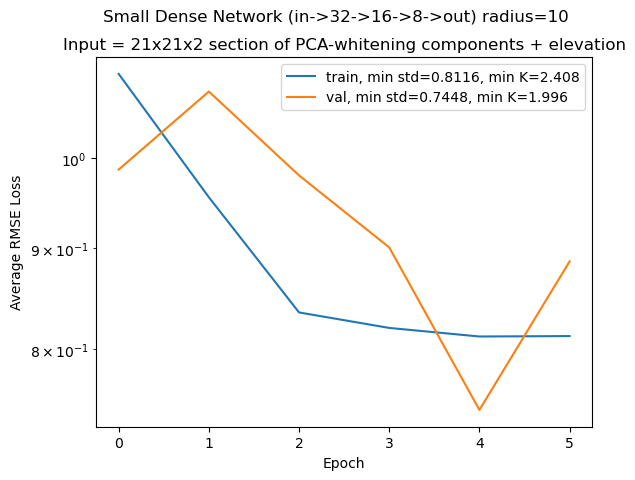

radius=10, n_components=3
 ToyModel(
  (linear1): Linear(in_features=1764, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):   1.219,  3.6157   	 Val (RMSE, K):  1.1311,  3.0319   	LR:  0.001	Time: 56.5
Epoch 001:     Train (RMSE, K):  0.91971,  2.7281   	 Val (RMSE, K):  1.0611,  2.8443   	LR:  0.001	Time: 57.7
Epoch 002:     Train (RMSE, K):  0.80915,  2.4001   	 Val (RMSE, K):  1.0381,  2.7825   	LR:  0.001	Time: 57.7
Epoch 003:     Train (RMSE, K):  0.80959,  2.4014   	 Val (RMSE, K):  0.91626,   2.456   	LR:  0.001	Time: 57.7
Epoch 004:     Train (RMSE, K):  0.79608,  2.3614   	 Val (RMSE, K):  0.78622,  2.1074   	LR:  0.001	Time: 57.7
Epoch 005:     Train (RMSE, K):  0.8165,  2.4219   	 Val (RMSE, K):  0.77156,  2.0681   	LR:  0.001	Time: 58.1


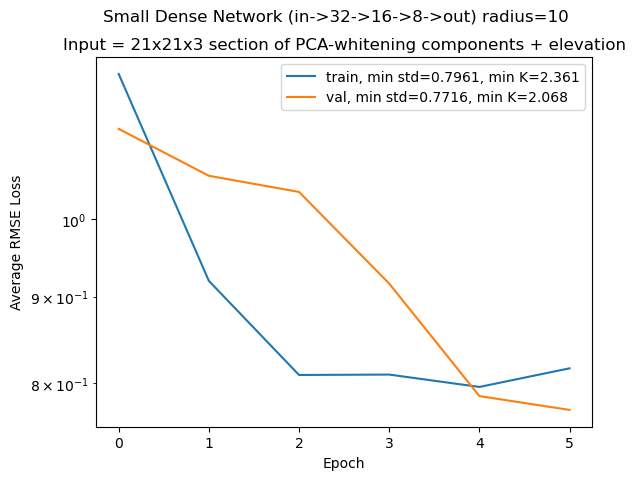

radius=10, n_components=4
 ToyModel(
  (linear1): Linear(in_features=2205, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2192,  3.6163   	 Val (RMSE, K):  1.3706,  3.6738   	LR:  0.001	Time: 56.3
Epoch 001:     Train (RMSE, K):  0.8753,  2.5963   	 Val (RMSE, K):  0.95351,  2.5558   	LR:  0.001	Time: 57.6
Epoch 002:     Train (RMSE, K):  0.81135,  2.4066   	 Val (RMSE, K):  1.1581,  3.1042   	LR:  0.001	Time: 57.6
Epoch 003:     Train (RMSE, K):  0.80782,  2.3962   	 Val (RMSE, K):  1.1266,  3.0199   	LR:  0.001	Time: 57.8
Epoch 004:     Train (RMSE, K):  0.79488,  2.3578   	 Val (RMSE, K):  1.1664,  3.1265   	LR:  0.001	Time: 57.9
Epoch 005:     Train (RMSE, K):  0.7895,  2.3418   	 Val (RMSE, K):  1.1397,  3.0549   	LR: 0.0002	Time: 58.0


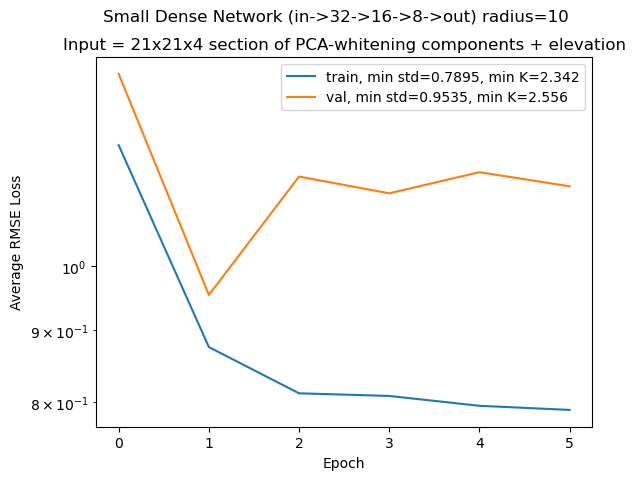

radius=10, n_components=5
 ToyModel(
  (linear1): Linear(in_features=2646, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2863,  3.8155   	 Val (RMSE, K):  1.0877,  2.9154   	LR:  0.001	Time: 56.7
Epoch 001:     Train (RMSE, K):  0.87262,  2.5884   	 Val (RMSE, K):  0.81722,  2.1905   	LR:  0.001	Time: 58.1
Epoch 002:     Train (RMSE, K):  0.84442,  2.5048   	 Val (RMSE, K):  0.99768,  2.6742   	LR:  0.001	Time: 58.2
Epoch 003:     Train (RMSE, K):  0.84094,  2.4944   	 Val (RMSE, K):  0.8484,  2.2741   	LR:  0.001	Time: 58.3
Epoch 004:     Train (RMSE, K):  0.84568,  2.5085   	 Val (RMSE, K):  0.83354,  2.2342   	LR:  0.001	Time: 58.2
Epoch 005:     Train (RMSE, K):  0.84471,  2.5056   	 Val (RMSE, K):  0.83115,  2.2278   	LR: 0.0002	Time: 58.3


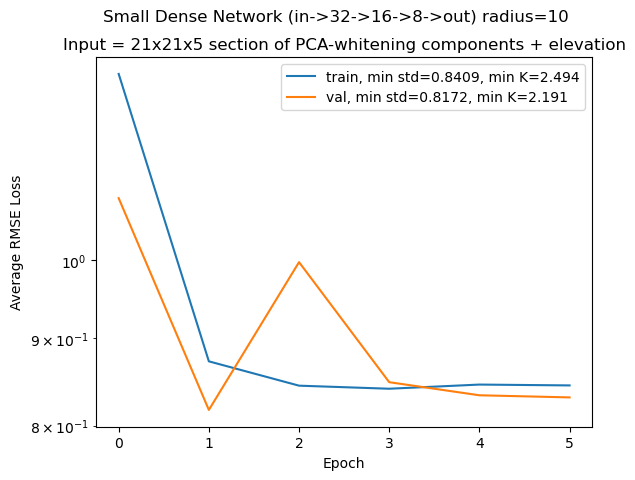

radius=10, n_components=6
 ToyModel(
  (linear1): Linear(in_features=3087, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.7298,  5.1309   	 Val (RMSE, K):  1.6108,  4.3177   	LR:  0.001	Time: 57.5
Epoch 001:     Train (RMSE, K):  0.84235,  2.4986   	 Val (RMSE, K):  0.82694,  2.2166   	LR:  0.001	Time: 59.5
Epoch 002:     Train (RMSE, K):  0.8045,  2.3863   	 Val (RMSE, K):  0.90178,  2.4171   	LR:  0.001	Time: 59.5
Epoch 003:     Train (RMSE, K):  0.80876,   2.399   	 Val (RMSE, K):  1.1119,  2.9803   	LR:  0.001	Time: 59.3
Epoch 004:     Train (RMSE, K):  0.79977,  2.3723   	 Val (RMSE, K):  1.0573,  2.8341   	LR:  0.001	Time: 59.6
Epoch 005:     Train (RMSE, K):  0.78575,  2.3307   	 Val (RMSE, K):  1.0617,  2.8458   	LR: 0.0002	Time: 59.7


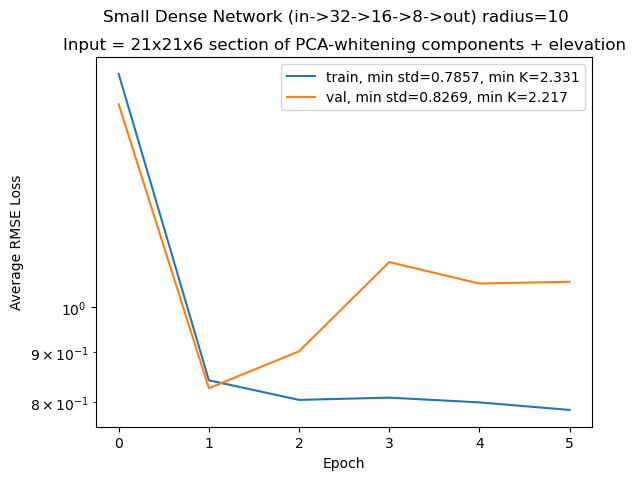

radius=10, n_components=7
 ToyModel(
  (linear1): Linear(in_features=3528, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.2933,  3.8364   	 Val (RMSE, K):  1.0812,  2.8981   	LR:  0.001	Time: 82.9
Epoch 001:     Train (RMSE, K):  0.99662,  2.9562   	 Val (RMSE, K):  0.88419,    2.37   	LR:  0.001	Time: 84.4
Epoch 002:     Train (RMSE, K):  0.84268,  2.4996   	 Val (RMSE, K):  1.1396,  3.0547   	LR:  0.001	Time: 84.3
Epoch 003:     Train (RMSE, K):  0.82996,  2.4618   	 Val (RMSE, K):  1.2155,   3.258   	LR:  0.001	Time: 85.1
Epoch 004:     Train (RMSE, K):  0.83365,  2.4728   	 Val (RMSE, K):  1.1681,  3.1309   	LR:  0.001	Time: 83.9
Epoch 005:     Train (RMSE, K):  0.83209,  2.4682   	 Val (RMSE, K):   1.187,  3.1815   	LR: 0.0002	Time: 84.3


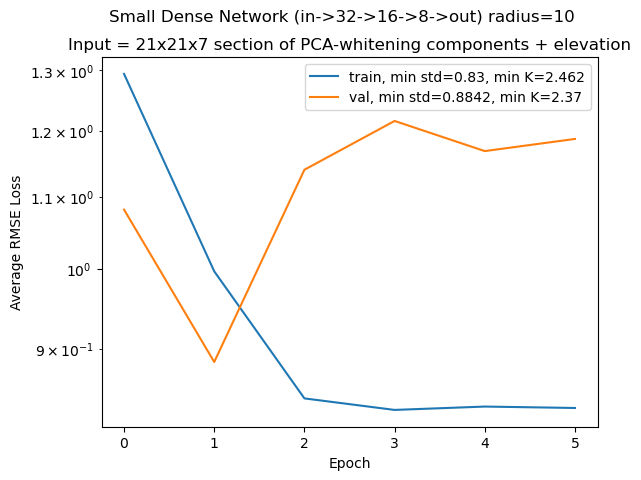

radius=10, n_components=8
 ToyModel(
  (linear1): Linear(in_features=3969, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.5076,  4.4719   	 Val (RMSE, K):  1.2962,  3.4744   	LR:  0.001	Time: 83.3
Epoch 001:     Train (RMSE, K):  0.85065,  2.5232   	 Val (RMSE, K):  0.83088,  2.2271   	LR:  0.001	Time: 85.6
Epoch 002:     Train (RMSE, K):  0.78904,  2.3405   	 Val (RMSE, K):  0.94065,  2.5213   	LR:  0.001	Time: 86.9
Epoch 003:     Train (RMSE, K):  0.7982,  2.3676   	 Val (RMSE, K):  1.1156,  2.9903   	LR:  0.001	Time: 86.6
Epoch 004:     Train (RMSE, K):  0.7885,  2.3389   	 Val (RMSE, K):  1.0028,  2.6879   	LR:  0.001	Time: 84.8
Epoch 005:     Train (RMSE, K):  0.77186,  2.2895   	 Val (RMSE, K):  0.99485,  2.6666   	LR: 0.0002	Time: 87.9


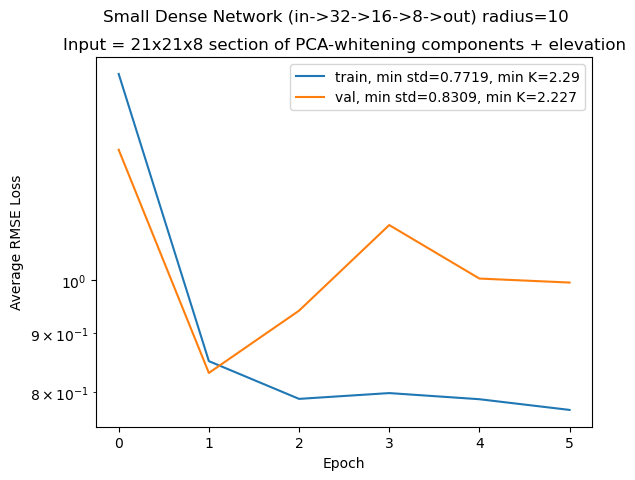

radius=12, n_components=2
 ToyModel(
  (linear1): Linear(in_features=1875, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.4406,   4.273   	 Val (RMSE, K):  1.1695,  3.1348   	LR:  0.001	Time: 71.5
Epoch 001:     Train (RMSE, K):  0.85234,  2.5282   	 Val (RMSE, K):  0.81572,  2.1865   	LR:  0.001	Time: 72.7
Epoch 002:     Train (RMSE, K):  0.82137,  2.4364   	 Val (RMSE, K):  1.0778,   2.889   	LR:  0.001	Time: 72.3
Epoch 003:     Train (RMSE, K):  0.81586,    2.42   	 Val (RMSE, K):  1.1546,  3.0948   	LR:  0.001	Time: 72.5
Epoch 004:     Train (RMSE, K):  0.88689,  2.6307   	 Val (RMSE, K):  1.0107,   2.709   	LR:  0.001	Time: 72.9
Epoch 005:     Train (RMSE, K):  0.88294,   2.619   	 Val (RMSE, K):   1.104,  2.9591   	LR: 0.0002	Time: 72.9


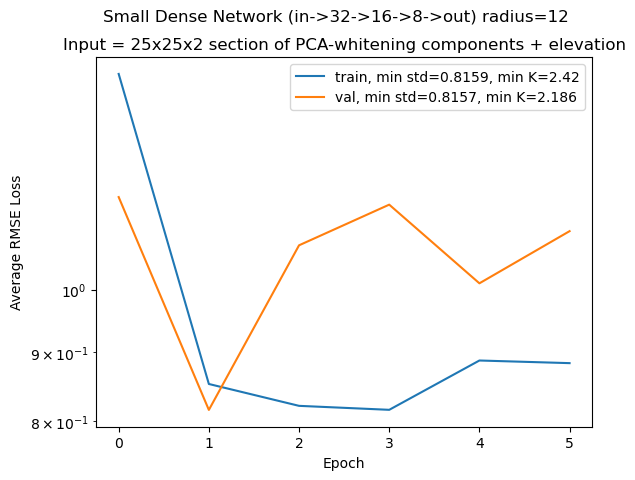

radius=12, n_components=3
 ToyModel(
  (linear1): Linear(in_features=2500, out_features=2, bias=True)
  (linear_output): Linear(in_features=2, out_features=1, bias=True)
  (layernorm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
)
Epoch 000:     Train (RMSE, K):  1.7237,  5.1129   	 Val (RMSE, K):  1.7647,  4.7301   	LR:  0.001	Time: 71.0
Epoch 001:     Train (RMSE, K):  0.91991,  2.7286   	 Val (RMSE, K):  1.0376,  2.7813   	LR:  0.001	Time: 72.7


In [15]:
importlib.reload(datasets.Datasets)
importlib.reload(models.Feedforward)
importlib.reload(utils.train)
importlib.reload(utils.eval)

batch_size = 256
val_batch_size = 1024

n_epochs = 5
dropout_rate = 0.5

stats_list = []
train_loss_array_list = []
val_loss_array_list = []
train_loss_list = []
val_loss_list = []

stats = None
print('Start Training', file=open(log_file_path, 'w'))
try:
    for combo in benchmark_combos:
        radius, n = combo

        omit_components = 244 - n

        # create datasets and dataloaders

        train_dataset = datasets.Datasets.PatchToPixelDataset(
            emit_data=emit_train,
            omit_components=omit_components,
            ecostress_data=eco_train,
            ecostress_center=None,
            ecostress_scale=None,
            additional_data=(elev_train,),
            radius=radius,
            boundary_width=max(
                [benchmark_combos[i][0] for i in range(len(benchmark_combos))]
            ),
        )

        val_dataset = datasets.Datasets.PatchToPixelDataset(
            emit_data=emit_val,
            omit_components=omit_components,
            ecostress_data=eco_val,
            ecostress_center=None,
            ecostress_scale=None,
            additional_data=(elev_val,),
            radius=radius,
            boundary_width=max(
                [benchmark_combos[i][0] for i in range(len(benchmark_combos))]
            ),
        )

        if batch_size is not None:
            train_loader = DataLoader(
                dataset=train_dataset,
                batch_size=batch_size,
                drop_last=False,
                shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset,
                batch_size=val_batch_size,
                drop_last=False,
                shuffle=False,
            )
        else:
            train_loader = DataLoader(
                dataset=train_dataset, batch_size=batch_size, shuffle=True,
            )
            val_loader = DataLoader(
                dataset=val_dataset, batch_size=batch_size, shuffle=False,
            )
            
        
        model = models.Feedforward.ToyModel(
            input_dim=train_dataset.input_dim,
            radius=radius,
            dropout_rate=dropout_rate,
        )
        
        if device == 'cuda':
            model = model.cuda()

        optimizer = optim.Adam(
            params=model.parameters(), lr=0.001, weight_decay=0, fused=True
        )

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer, factor=0.2, patience=2
        )

        loss_fn = nn.MSELoss(reduction='sum')

        print(f'radius={combo[0]}, n_components={combo[1]}\n', model)
        print(
            f'radius={combo[0]}, n_components={combo[1]}\n',
            model,
            file=open(log_file_path, 'a'),
        )
        
        train_loss, val_loss, eval_stats, train_loss_array, val_loss_array = (
            utils.train.train(
                model,
                optimizer,
                scheduler,
                loss_fn,
                train_loader,
                val_loader,
                n_epochs=n_epochs,
                loss_interval=1,
                # preexisting_losses=[train_loss, val_loss],
                device=device,
                log_file_path=log_file_path,
            )
        )
        
        eval_stats = np.concatenate([np.array(combo), eval_stats])
        stats_list.append(eval_stats)
        train_loss_array_list.append(train_loss_array)
        val_loss_array_list.append(val_loss_array)
        train_loss_list.append(train_loss)
        val_loss_array_list.append(val_loss)
        
        
        fig, ax = plt.subplots()
        fig.suptitle(
            f'Small Dense Network (in->32->16->8->out) radius={radius}'
        )
        l = 2 * radius + 1
        ax.set_title(
            f'Input = {l}x{l}x{244 - omit_components} section of '
            'PCA-whitening components + elevation'
        )
        ax.semilogy(
            np.arange(len(train_loss)),
            train_loss,
            label=(
                'train, '
                f'min std={min(train_loss):.4}, '
                f'min K={train_dataset.ecostress_scale * min(train_loss):.4}'
            ),
        )
        ax.semilogy(
            np.arange(len(val_loss)),
            val_loss,
            label=(
                'val, '
                f'min std={min(val_loss):.4}, '
                f'min K={val_dataset.ecostress_scale * min(val_loss):.4}'
            ),
        )
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Average RMSE Loss')
        ax.legend()
        plt.show(fig)
        
        torch.save(
            model.state_dict(),
            join_path(f'Data\\Models\\linear_r{radius}_n{n}.pt')
        )
        
    stats = np.array(stats_list)
    stats_columns = utils.eval.initialize_eval_results().columns.to_list()
    stats = pd.DataFrame(stats, columns=stats_columns)
    stats['radius'] = stats['radius'].astype(int)
    stats['n_components'] = stats['n_components'].astype(int)
        
except KeyboardInterrupt:
    print('Training was interrupted by user')
    print('Training was interrupted by user', file=open(log_file_path, 'a'))

stats

In [20]:
stats.to_csv(join_path(r'Miscellaneous\small_nn_benchmarking_pca_temp4.csv'))

In [21]:
stats.iloc[:,35].min()

0.383429458303773

In [19]:
stats.columns

Index(['radius', 'n_components', 'train_avg_std', 'train_std_std',
       'train_std_min', 'train_std_0.5pct', 'train_std_2.5pct',
       'train_std_16pct', 'train_std_25pct', 'train_std_50pct',
       'train_std_75pct', 'train_std_84pct', 'train_std_97.5pct',
       'train_std_99.5pct', 'train_std_max', 'train_avg_K', 'train_std_K',
       'train_K_min', 'train_K_0.5pct', 'train_K_2.5pct', 'train_K_16pct',
       'train_K_25pct', 'train_K_50pct', 'train_K_75pct', 'train_K_84pct',
       'train_K_97.5pct', 'train_K_99.5pct', 'train_K_max', 'val_avg_std',
       'val_std_std', 'val_std_min', 'val_std_0.5pct', 'val_std_2.5pct',
       'val_std_16pct', 'val_std_25pct', 'val_std_50pct', 'val_std_75pct',
       'val_std_84pct', 'val_std_97.5pct', 'val_std_99.5pct', 'val_std_max',
       'val_avg_K', 'val_std_K', 'val_K_min', 'val_K_0.5pct', 'val_K_2.5pct',
       'val_K_16pct', 'val_K_25pct', 'val_K_50pct', 'val_K_75pct',
       'val_K_84pct', 'val_K_97.5pct', 'val_K_99.5pct', 'val_K_max'],

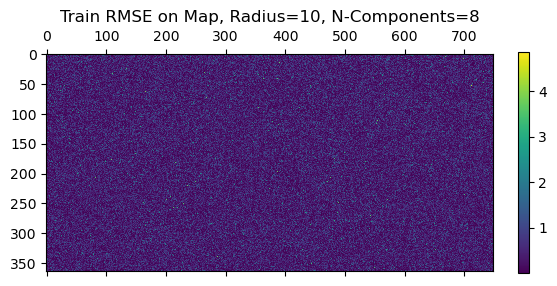

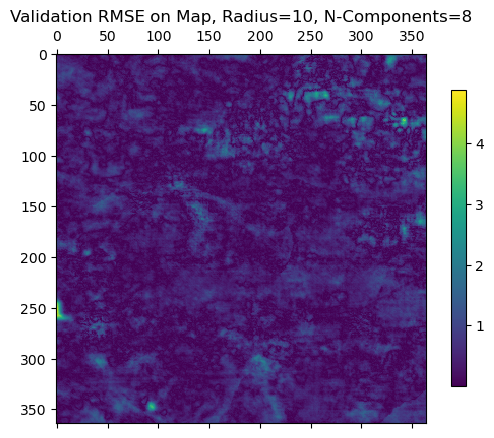

In [25]:
fig, ax = plt.subplots()
ax.set_title('Train RMSE on Map, Radius=10, N-Components=8')
plt.imshow(train_loss_array)
plt.colorbar(fraction=0.05, shrink=0.6)
ax.matshow(train_loss_array)
plt.show(fig)
fig, ax = plt.subplots()
ax.set_title('Validation RMSE on Map, Radius=10, N-Components=8')
plt.imshow(train_loss_array)
plt.colorbar(fraction=0.05, shrink=0.8)
ax.matshow(val_loss_array)
plt.show(fig)

In [ ]:
n_components_benchmark_radii = [0]
#[0, 1, 3, 8, 16]
n_components_benchmark_n_components = [1, 2, 3, 4, 5, 8, 10, 12, 16,]
#[1, 2, 3, 4, 8, 16, 32, 64, 128, 244]

radius_benchmark_radii = []#[0, 1, 2, 3, 4, 8, 16]
radius_benchmark_n_components = []#[8, 16, 32, 64, 244]

benchmark_combos = []
for radius in n_components_benchmark_radii:
    for n in n_components_benchmark_n_components:
        benchmark_combos.append((radius, n))

for radius in radius_benchmark_radii:
    for n in radius_benchmark_n_components:
        if (radius, n) in benchmark_combos:
            continue
        else:
            benchmark_combos.append((radius, n))

len(benchmark_combos)

1